In [1]:
import pandas as pd
import numpy as np
import ast

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn, optim
from torchvision import datasets, utils, models
# from torchinfo import summary
import torch.nn.functional as F
from torchvision.transforms import v2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import altair as alt
alt.data_transformers.enable("vegafusion")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import multiprocessing

In [2]:
# Change csv name as needed
labels_extended = pd.read_csv('data/selected_gene_df.csv')
clean_possible_genes = labels_extended.columns.to_list()[7:]
num_labels = len(clean_possible_genes)

In [ ]:
train_df, test_df = train_test_split(labels_extended, train_size=0.85, random_state=123)
# test_df.set_index('index', inplace=True)
print(f'Shape of trainset: {train_df.shape}')
print(f'Shape of testset: {test_df.shape}')

Shape of trainset: (41416, 37)
Shape of testset: (7309, 37)


In [4]:
class PythonGeneDataset(Dataset):
    def __init__(self, labels_df, img_dir, indices=None, transform=None):
        self.labels_df = labels_df
        if indices is not None:
            self.labels_df = self.labels_df.iloc[indices]
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.labels_df.iloc[idx, 0]}.png")
        image = Image.open(img_name)
        # Parse labels here based on your CSV structure and required format
        labels = torch.tensor(self.labels_df.iloc[idx, 7:].astype('float32').values)
        
        if self.transform:
            image = self.transform(image)

        return image, labels


In [5]:
IMAGE_SIZE = 480

new_layers = nn.Sequential(
    nn.LazyLinear(1280),  
    nn.BatchNorm1d(1280),
    nn.ReLU(),             
    nn.Dropout(0.5),       
    nn.LazyLinear(num_labels)
)

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToDtype(torch.float16, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

full_dataset = PythonGeneDataset(labels_df=train_df, img_dir='data/img/', transform=transform)

# Split dataset
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = total_size - train_size
train_indices, valid_indices = torch.utils.data.random_split(np.arange(total_size), [train_size, valid_size])

# Create train and validation datasets
train_dataset = Subset(full_dataset, train_indices)
valid_dataset = Subset(full_dataset, valid_indices)

# Initialize DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=multiprocessing.cpu_count())
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=multiprocessing.cpu_count())

/opt/conda/envs/deep-learning/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Predictions

In [7]:
efficientnet = models.efficientnet_v2_l(weights='EfficientNet_V2_L_Weights.DEFAULT')
efficientnet.classifier = new_layers

# If using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

checkpoint = torch.load(f'model/model_v8_epoch9.pt', map_location=device)
efficientnet.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['valid_loss']

efficientnet.eval()

efficientnet.to(device)
print(f"{train_loss}, {valid_loss}")

cuda


RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "features.0.0.weight", "features.0.1.weight", "features.0.1.bias", "features.0.1.running_mean", "features.0.1.running_var", "features.1.0.block.0.0.weight", "features.1.0.block.0.1.weight", "features.1.0.block.0.1.bias", "features.1.0.block.0.1.running_mean", "features.1.0.block.0.1.running_var", "features.1.1.block.0.0.weight", "features.1.1.block.0.1.weight", "features.1.1.block.0.1.bias", "features.1.1.block.0.1.running_mean", "features.1.1.block.0.1.running_var", "features.1.2.block.0.0.weight", "features.1.2.block.0.1.weight", "features.1.2.block.0.1.bias", "features.1.2.block.0.1.running_mean", "features.1.2.block.0.1.running_var", "features.1.3.block.0.0.weight", "features.1.3.block.0.1.weight", "features.1.3.block.0.1.bias", "features.1.3.block.0.1.running_mean", "features.1.3.block.0.1.running_var", "features.2.0.block.0.0.weight", "features.2.0.block.0.1.weight", "features.2.0.block.0.1.bias", "features.2.0.block.0.1.running_mean", "features.2.0.block.0.1.running_var", "features.2.0.block.1.0.weight", "features.2.0.block.1.1.weight", "features.2.0.block.1.1.bias", "features.2.0.block.1.1.running_mean", "features.2.0.block.1.1.running_var", "features.2.1.block.0.0.weight", "features.2.1.block.0.1.weight", "features.2.1.block.0.1.bias", "features.2.1.block.0.1.running_mean", "features.2.1.block.0.1.running_var", "features.2.1.block.1.0.weight", "features.2.1.block.1.1.weight", "features.2.1.block.1.1.bias", "features.2.1.block.1.1.running_mean", "features.2.1.block.1.1.running_var", "features.2.2.block.0.0.weight", "features.2.2.block.0.1.weight", "features.2.2.block.0.1.bias", "features.2.2.block.0.1.running_mean", "features.2.2.block.0.1.running_var", "features.2.2.block.1.0.weight", "features.2.2.block.1.1.weight", "features.2.2.block.1.1.bias", "features.2.2.block.1.1.running_mean", "features.2.2.block.1.1.running_var", "features.2.3.block.0.0.weight", "features.2.3.block.0.1.weight", "features.2.3.block.0.1.bias", "features.2.3.block.0.1.running_mean", "features.2.3.block.0.1.running_var", "features.2.3.block.1.0.weight", "features.2.3.block.1.1.weight", "features.2.3.block.1.1.bias", "features.2.3.block.1.1.running_mean", "features.2.3.block.1.1.running_var", "features.2.4.block.0.0.weight", "features.2.4.block.0.1.weight", "features.2.4.block.0.1.bias", "features.2.4.block.0.1.running_mean", "features.2.4.block.0.1.running_var", "features.2.4.block.1.0.weight", "features.2.4.block.1.1.weight", "features.2.4.block.1.1.bias", "features.2.4.block.1.1.running_mean", "features.2.4.block.1.1.running_var", "features.2.5.block.0.0.weight", "features.2.5.block.0.1.weight", "features.2.5.block.0.1.bias", "features.2.5.block.0.1.running_mean", "features.2.5.block.0.1.running_var", "features.2.5.block.1.0.weight", "features.2.5.block.1.1.weight", "features.2.5.block.1.1.bias", "features.2.5.block.1.1.running_mean", "features.2.5.block.1.1.running_var", "features.2.6.block.0.0.weight", "features.2.6.block.0.1.weight", "features.2.6.block.0.1.bias", "features.2.6.block.0.1.running_mean", "features.2.6.block.0.1.running_var", "features.2.6.block.1.0.weight", "features.2.6.block.1.1.weight", "features.2.6.block.1.1.bias", "features.2.6.block.1.1.running_mean", "features.2.6.block.1.1.running_var", "features.3.0.block.0.0.weight", "features.3.0.block.0.1.weight", "features.3.0.block.0.1.bias", "features.3.0.block.0.1.running_mean", "features.3.0.block.0.1.running_var", "features.3.0.block.1.0.weight", "features.3.0.block.1.1.weight", "features.3.0.block.1.1.bias", "features.3.0.block.1.1.running_mean", "features.3.0.block.1.1.running_var", "features.3.1.block.0.0.weight", "features.3.1.block.0.1.weight", "features.3.1.block.0.1.bias", "features.3.1.block.0.1.running_mean", "features.3.1.block.0.1.running_var", "features.3.1.block.1.0.weight", "features.3.1.block.1.1.weight", "features.3.1.block.1.1.bias", "features.3.1.block.1.1.running_mean", "features.3.1.block.1.1.running_var", "features.3.2.block.0.0.weight", "features.3.2.block.0.1.weight", "features.3.2.block.0.1.bias", "features.3.2.block.0.1.running_mean", "features.3.2.block.0.1.running_var", "features.3.2.block.1.0.weight", "features.3.2.block.1.1.weight", "features.3.2.block.1.1.bias", "features.3.2.block.1.1.running_mean", "features.3.2.block.1.1.running_var", "features.3.3.block.0.0.weight", "features.3.3.block.0.1.weight", "features.3.3.block.0.1.bias", "features.3.3.block.0.1.running_mean", "features.3.3.block.0.1.running_var", "features.3.3.block.1.0.weight", "features.3.3.block.1.1.weight", "features.3.3.block.1.1.bias", "features.3.3.block.1.1.running_mean", "features.3.3.block.1.1.running_var", "features.3.4.block.0.0.weight", "features.3.4.block.0.1.weight", "features.3.4.block.0.1.bias", "features.3.4.block.0.1.running_mean", "features.3.4.block.0.1.running_var", "features.3.4.block.1.0.weight", "features.3.4.block.1.1.weight", "features.3.4.block.1.1.bias", "features.3.4.block.1.1.running_mean", "features.3.4.block.1.1.running_var", "features.3.5.block.0.0.weight", "features.3.5.block.0.1.weight", "features.3.5.block.0.1.bias", "features.3.5.block.0.1.running_mean", "features.3.5.block.0.1.running_var", "features.3.5.block.1.0.weight", "features.3.5.block.1.1.weight", "features.3.5.block.1.1.bias", "features.3.5.block.1.1.running_mean", "features.3.5.block.1.1.running_var", "features.3.6.block.0.0.weight", "features.3.6.block.0.1.weight", "features.3.6.block.0.1.bias", "features.3.6.block.0.1.running_mean", "features.3.6.block.0.1.running_var", "features.3.6.block.1.0.weight", "features.3.6.block.1.1.weight", "features.3.6.block.1.1.bias", "features.3.6.block.1.1.running_mean", "features.3.6.block.1.1.running_var", "features.4.0.block.0.0.weight", "features.4.0.block.0.1.weight", "features.4.0.block.0.1.bias", "features.4.0.block.0.1.running_mean", "features.4.0.block.0.1.running_var", "features.4.0.block.1.0.weight", "features.4.0.block.1.1.weight", "features.4.0.block.1.1.bias", "features.4.0.block.1.1.running_mean", "features.4.0.block.1.1.running_var", "features.4.0.block.2.fc1.weight", "features.4.0.block.2.fc1.bias", "features.4.0.block.2.fc2.weight", "features.4.0.block.2.fc2.bias", "features.4.0.block.3.0.weight", "features.4.0.block.3.1.weight", "features.4.0.block.3.1.bias", "features.4.0.block.3.1.running_mean", "features.4.0.block.3.1.running_var", "features.4.1.block.0.0.weight", "features.4.1.block.0.1.weight", "features.4.1.block.0.1.bias", "features.4.1.block.0.1.running_mean", "features.4.1.block.0.1.running_var", "features.4.1.block.1.0.weight", "features.4.1.block.1.1.weight", "features.4.1.block.1.1.bias", "features.4.1.block.1.1.running_mean", "features.4.1.block.1.1.running_var", "features.4.1.block.2.fc1.weight", "features.4.1.block.2.fc1.bias", "features.4.1.block.2.fc2.weight", "features.4.1.block.2.fc2.bias", "features.4.1.block.3.0.weight", "features.4.1.block.3.1.weight", "features.4.1.block.3.1.bias", "features.4.1.block.3.1.running_mean", "features.4.1.block.3.1.running_var", "features.4.2.block.0.0.weight", "features.4.2.block.0.1.weight", "features.4.2.block.0.1.bias", "features.4.2.block.0.1.running_mean", "features.4.2.block.0.1.running_var", "features.4.2.block.1.0.weight", "features.4.2.block.1.1.weight", "features.4.2.block.1.1.bias", "features.4.2.block.1.1.running_mean", "features.4.2.block.1.1.running_var", "features.4.2.block.2.fc1.weight", "features.4.2.block.2.fc1.bias", "features.4.2.block.2.fc2.weight", "features.4.2.block.2.fc2.bias", "features.4.2.block.3.0.weight", "features.4.2.block.3.1.weight", "features.4.2.block.3.1.bias", "features.4.2.block.3.1.running_mean", "features.4.2.block.3.1.running_var", "features.4.3.block.0.0.weight", "features.4.3.block.0.1.weight", "features.4.3.block.0.1.bias", "features.4.3.block.0.1.running_mean", "features.4.3.block.0.1.running_var", "features.4.3.block.1.0.weight", "features.4.3.block.1.1.weight", "features.4.3.block.1.1.bias", "features.4.3.block.1.1.running_mean", "features.4.3.block.1.1.running_var", "features.4.3.block.2.fc1.weight", "features.4.3.block.2.fc1.bias", "features.4.3.block.2.fc2.weight", "features.4.3.block.2.fc2.bias", "features.4.3.block.3.0.weight", "features.4.3.block.3.1.weight", "features.4.3.block.3.1.bias", "features.4.3.block.3.1.running_mean", "features.4.3.block.3.1.running_var", "features.4.4.block.0.0.weight", "features.4.4.block.0.1.weight", "features.4.4.block.0.1.bias", "features.4.4.block.0.1.running_mean", "features.4.4.block.0.1.running_var", "features.4.4.block.1.0.weight", "features.4.4.block.1.1.weight", "features.4.4.block.1.1.bias", "features.4.4.block.1.1.running_mean", "features.4.4.block.1.1.running_var", "features.4.4.block.2.fc1.weight", "features.4.4.block.2.fc1.bias", "features.4.4.block.2.fc2.weight", "features.4.4.block.2.fc2.bias", "features.4.4.block.3.0.weight", "features.4.4.block.3.1.weight", "features.4.4.block.3.1.bias", "features.4.4.block.3.1.running_mean", "features.4.4.block.3.1.running_var", "features.4.5.block.0.0.weight", "features.4.5.block.0.1.weight", "features.4.5.block.0.1.bias", "features.4.5.block.0.1.running_mean", "features.4.5.block.0.1.running_var", "features.4.5.block.1.0.weight", "features.4.5.block.1.1.weight", "features.4.5.block.1.1.bias", "features.4.5.block.1.1.running_mean", "features.4.5.block.1.1.running_var", "features.4.5.block.2.fc1.weight", "features.4.5.block.2.fc1.bias", "features.4.5.block.2.fc2.weight", "features.4.5.block.2.fc2.bias", "features.4.5.block.3.0.weight", "features.4.5.block.3.1.weight", "features.4.5.block.3.1.bias", "features.4.5.block.3.1.running_mean", "features.4.5.block.3.1.running_var", "features.4.6.block.0.0.weight", "features.4.6.block.0.1.weight", "features.4.6.block.0.1.bias", "features.4.6.block.0.1.running_mean", "features.4.6.block.0.1.running_var", "features.4.6.block.1.0.weight", "features.4.6.block.1.1.weight", "features.4.6.block.1.1.bias", "features.4.6.block.1.1.running_mean", "features.4.6.block.1.1.running_var", "features.4.6.block.2.fc1.weight", "features.4.6.block.2.fc1.bias", "features.4.6.block.2.fc2.weight", "features.4.6.block.2.fc2.bias", "features.4.6.block.3.0.weight", "features.4.6.block.3.1.weight", "features.4.6.block.3.1.bias", "features.4.6.block.3.1.running_mean", "features.4.6.block.3.1.running_var", "features.4.7.block.0.0.weight", "features.4.7.block.0.1.weight", "features.4.7.block.0.1.bias", "features.4.7.block.0.1.running_mean", "features.4.7.block.0.1.running_var", "features.4.7.block.1.0.weight", "features.4.7.block.1.1.weight", "features.4.7.block.1.1.bias", "features.4.7.block.1.1.running_mean", "features.4.7.block.1.1.running_var", "features.4.7.block.2.fc1.weight", "features.4.7.block.2.fc1.bias", "features.4.7.block.2.fc2.weight", "features.4.7.block.2.fc2.bias", "features.4.7.block.3.0.weight", "features.4.7.block.3.1.weight", "features.4.7.block.3.1.bias", "features.4.7.block.3.1.running_mean", "features.4.7.block.3.1.running_var", "features.4.8.block.0.0.weight", "features.4.8.block.0.1.weight", "features.4.8.block.0.1.bias", "features.4.8.block.0.1.running_mean", "features.4.8.block.0.1.running_var", "features.4.8.block.1.0.weight", "features.4.8.block.1.1.weight", "features.4.8.block.1.1.bias", "features.4.8.block.1.1.running_mean", "features.4.8.block.1.1.running_var", "features.4.8.block.2.fc1.weight", "features.4.8.block.2.fc1.bias", "features.4.8.block.2.fc2.weight", "features.4.8.block.2.fc2.bias", "features.4.8.block.3.0.weight", "features.4.8.block.3.1.weight", "features.4.8.block.3.1.bias", "features.4.8.block.3.1.running_mean", "features.4.8.block.3.1.running_var", "features.4.9.block.0.0.weight", "features.4.9.block.0.1.weight", "features.4.9.block.0.1.bias", "features.4.9.block.0.1.running_mean", "features.4.9.block.0.1.running_var", "features.4.9.block.1.0.weight", "features.4.9.block.1.1.weight", "features.4.9.block.1.1.bias", "features.4.9.block.1.1.running_mean", "features.4.9.block.1.1.running_var", "features.4.9.block.2.fc1.weight", "features.4.9.block.2.fc1.bias", "features.4.9.block.2.fc2.weight", "features.4.9.block.2.fc2.bias", "features.4.9.block.3.0.weight", "features.4.9.block.3.1.weight", "features.4.9.block.3.1.bias", "features.4.9.block.3.1.running_mean", "features.4.9.block.3.1.running_var", "features.5.0.block.0.0.weight", "features.5.0.block.0.1.weight", "features.5.0.block.0.1.bias", "features.5.0.block.0.1.running_mean", "features.5.0.block.0.1.running_var", "features.5.0.block.1.0.weight", "features.5.0.block.1.1.weight", "features.5.0.block.1.1.bias", "features.5.0.block.1.1.running_mean", "features.5.0.block.1.1.running_var", "features.5.0.block.2.fc1.weight", "features.5.0.block.2.fc1.bias", "features.5.0.block.2.fc2.weight", "features.5.0.block.2.fc2.bias", "features.5.0.block.3.0.weight", "features.5.0.block.3.1.weight", "features.5.0.block.3.1.bias", "features.5.0.block.3.1.running_mean", "features.5.0.block.3.1.running_var", "features.5.1.block.0.0.weight", "features.5.1.block.0.1.weight", "features.5.1.block.0.1.bias", "features.5.1.block.0.1.running_mean", "features.5.1.block.0.1.running_var", "features.5.1.block.1.0.weight", "features.5.1.block.1.1.weight", "features.5.1.block.1.1.bias", "features.5.1.block.1.1.running_mean", "features.5.1.block.1.1.running_var", "features.5.1.block.2.fc1.weight", "features.5.1.block.2.fc1.bias", "features.5.1.block.2.fc2.weight", "features.5.1.block.2.fc2.bias", "features.5.1.block.3.0.weight", "features.5.1.block.3.1.weight", "features.5.1.block.3.1.bias", "features.5.1.block.3.1.running_mean", "features.5.1.block.3.1.running_var", "features.5.2.block.0.0.weight", "features.5.2.block.0.1.weight", "features.5.2.block.0.1.bias", "features.5.2.block.0.1.running_mean", "features.5.2.block.0.1.running_var", "features.5.2.block.1.0.weight", "features.5.2.block.1.1.weight", "features.5.2.block.1.1.bias", "features.5.2.block.1.1.running_mean", "features.5.2.block.1.1.running_var", "features.5.2.block.2.fc1.weight", "features.5.2.block.2.fc1.bias", "features.5.2.block.2.fc2.weight", "features.5.2.block.2.fc2.bias", "features.5.2.block.3.0.weight", "features.5.2.block.3.1.weight", "features.5.2.block.3.1.bias", "features.5.2.block.3.1.running_mean", "features.5.2.block.3.1.running_var", "features.5.3.block.0.0.weight", "features.5.3.block.0.1.weight", "features.5.3.block.0.1.bias", "features.5.3.block.0.1.running_mean", "features.5.3.block.0.1.running_var", "features.5.3.block.1.0.weight", "features.5.3.block.1.1.weight", "features.5.3.block.1.1.bias", "features.5.3.block.1.1.running_mean", "features.5.3.block.1.1.running_var", "features.5.3.block.2.fc1.weight", "features.5.3.block.2.fc1.bias", "features.5.3.block.2.fc2.weight", "features.5.3.block.2.fc2.bias", "features.5.3.block.3.0.weight", "features.5.3.block.3.1.weight", "features.5.3.block.3.1.bias", "features.5.3.block.3.1.running_mean", "features.5.3.block.3.1.running_var", "features.5.4.block.0.0.weight", "features.5.4.block.0.1.weight", "features.5.4.block.0.1.bias", "features.5.4.block.0.1.running_mean", "features.5.4.block.0.1.running_var", "features.5.4.block.1.0.weight", "features.5.4.block.1.1.weight", "features.5.4.block.1.1.bias", "features.5.4.block.1.1.running_mean", "features.5.4.block.1.1.running_var", "features.5.4.block.2.fc1.weight", "features.5.4.block.2.fc1.bias", "features.5.4.block.2.fc2.weight", "features.5.4.block.2.fc2.bias", "features.5.4.block.3.0.weight", "features.5.4.block.3.1.weight", "features.5.4.block.3.1.bias", "features.5.4.block.3.1.running_mean", "features.5.4.block.3.1.running_var", "features.5.5.block.0.0.weight", "features.5.5.block.0.1.weight", "features.5.5.block.0.1.bias", "features.5.5.block.0.1.running_mean", "features.5.5.block.0.1.running_var", "features.5.5.block.1.0.weight", "features.5.5.block.1.1.weight", "features.5.5.block.1.1.bias", "features.5.5.block.1.1.running_mean", "features.5.5.block.1.1.running_var", "features.5.5.block.2.fc1.weight", "features.5.5.block.2.fc1.bias", "features.5.5.block.2.fc2.weight", "features.5.5.block.2.fc2.bias", "features.5.5.block.3.0.weight", "features.5.5.block.3.1.weight", "features.5.5.block.3.1.bias", "features.5.5.block.3.1.running_mean", "features.5.5.block.3.1.running_var", "features.5.6.block.0.0.weight", "features.5.6.block.0.1.weight", "features.5.6.block.0.1.bias", "features.5.6.block.0.1.running_mean", "features.5.6.block.0.1.running_var", "features.5.6.block.1.0.weight", "features.5.6.block.1.1.weight", "features.5.6.block.1.1.bias", "features.5.6.block.1.1.running_mean", "features.5.6.block.1.1.running_var", "features.5.6.block.2.fc1.weight", "features.5.6.block.2.fc1.bias", "features.5.6.block.2.fc2.weight", "features.5.6.block.2.fc2.bias", "features.5.6.block.3.0.weight", "features.5.6.block.3.1.weight", "features.5.6.block.3.1.bias", "features.5.6.block.3.1.running_mean", "features.5.6.block.3.1.running_var", "features.5.7.block.0.0.weight", "features.5.7.block.0.1.weight", "features.5.7.block.0.1.bias", "features.5.7.block.0.1.running_mean", "features.5.7.block.0.1.running_var", "features.5.7.block.1.0.weight", "features.5.7.block.1.1.weight", "features.5.7.block.1.1.bias", "features.5.7.block.1.1.running_mean", "features.5.7.block.1.1.running_var", "features.5.7.block.2.fc1.weight", "features.5.7.block.2.fc1.bias", "features.5.7.block.2.fc2.weight", "features.5.7.block.2.fc2.bias", "features.5.7.block.3.0.weight", "features.5.7.block.3.1.weight", "features.5.7.block.3.1.bias", "features.5.7.block.3.1.running_mean", "features.5.7.block.3.1.running_var", "features.5.8.block.0.0.weight", "features.5.8.block.0.1.weight", "features.5.8.block.0.1.bias", "features.5.8.block.0.1.running_mean", "features.5.8.block.0.1.running_var", "features.5.8.block.1.0.weight", "features.5.8.block.1.1.weight", "features.5.8.block.1.1.bias", "features.5.8.block.1.1.running_mean", "features.5.8.block.1.1.running_var", "features.5.8.block.2.fc1.weight", "features.5.8.block.2.fc1.bias", "features.5.8.block.2.fc2.weight", "features.5.8.block.2.fc2.bias", "features.5.8.block.3.0.weight", "features.5.8.block.3.1.weight", "features.5.8.block.3.1.bias", "features.5.8.block.3.1.running_mean", "features.5.8.block.3.1.running_var", "features.5.9.block.0.0.weight", "features.5.9.block.0.1.weight", "features.5.9.block.0.1.bias", "features.5.9.block.0.1.running_mean", "features.5.9.block.0.1.running_var", "features.5.9.block.1.0.weight", "features.5.9.block.1.1.weight", "features.5.9.block.1.1.bias", "features.5.9.block.1.1.running_mean", "features.5.9.block.1.1.running_var", "features.5.9.block.2.fc1.weight", "features.5.9.block.2.fc1.bias", "features.5.9.block.2.fc2.weight", "features.5.9.block.2.fc2.bias", "features.5.9.block.3.0.weight", "features.5.9.block.3.1.weight", "features.5.9.block.3.1.bias", "features.5.9.block.3.1.running_mean", "features.5.9.block.3.1.running_var", "features.5.10.block.0.0.weight", "features.5.10.block.0.1.weight", "features.5.10.block.0.1.bias", "features.5.10.block.0.1.running_mean", "features.5.10.block.0.1.running_var", "features.5.10.block.1.0.weight", "features.5.10.block.1.1.weight", "features.5.10.block.1.1.bias", "features.5.10.block.1.1.running_mean", "features.5.10.block.1.1.running_var", "features.5.10.block.2.fc1.weight", "features.5.10.block.2.fc1.bias", "features.5.10.block.2.fc2.weight", "features.5.10.block.2.fc2.bias", "features.5.10.block.3.0.weight", "features.5.10.block.3.1.weight", "features.5.10.block.3.1.bias", "features.5.10.block.3.1.running_mean", "features.5.10.block.3.1.running_var", "features.5.11.block.0.0.weight", "features.5.11.block.0.1.weight", "features.5.11.block.0.1.bias", "features.5.11.block.0.1.running_mean", "features.5.11.block.0.1.running_var", "features.5.11.block.1.0.weight", "features.5.11.block.1.1.weight", "features.5.11.block.1.1.bias", "features.5.11.block.1.1.running_mean", "features.5.11.block.1.1.running_var", "features.5.11.block.2.fc1.weight", "features.5.11.block.2.fc1.bias", "features.5.11.block.2.fc2.weight", "features.5.11.block.2.fc2.bias", "features.5.11.block.3.0.weight", "features.5.11.block.3.1.weight", "features.5.11.block.3.1.bias", "features.5.11.block.3.1.running_mean", "features.5.11.block.3.1.running_var", "features.5.12.block.0.0.weight", "features.5.12.block.0.1.weight", "features.5.12.block.0.1.bias", "features.5.12.block.0.1.running_mean", "features.5.12.block.0.1.running_var", "features.5.12.block.1.0.weight", "features.5.12.block.1.1.weight", "features.5.12.block.1.1.bias", "features.5.12.block.1.1.running_mean", "features.5.12.block.1.1.running_var", "features.5.12.block.2.fc1.weight", "features.5.12.block.2.fc1.bias", "features.5.12.block.2.fc2.weight", "features.5.12.block.2.fc2.bias", "features.5.12.block.3.0.weight", "features.5.12.block.3.1.weight", "features.5.12.block.3.1.bias", "features.5.12.block.3.1.running_mean", "features.5.12.block.3.1.running_var", "features.5.13.block.0.0.weight", "features.5.13.block.0.1.weight", "features.5.13.block.0.1.bias", "features.5.13.block.0.1.running_mean", "features.5.13.block.0.1.running_var", "features.5.13.block.1.0.weight", "features.5.13.block.1.1.weight", "features.5.13.block.1.1.bias", "features.5.13.block.1.1.running_mean", "features.5.13.block.1.1.running_var", "features.5.13.block.2.fc1.weight", "features.5.13.block.2.fc1.bias", "features.5.13.block.2.fc2.weight", "features.5.13.block.2.fc2.bias", "features.5.13.block.3.0.weight", "features.5.13.block.3.1.weight", "features.5.13.block.3.1.bias", "features.5.13.block.3.1.running_mean", "features.5.13.block.3.1.running_var", "features.5.14.block.0.0.weight", "features.5.14.block.0.1.weight", "features.5.14.block.0.1.bias", "features.5.14.block.0.1.running_mean", "features.5.14.block.0.1.running_var", "features.5.14.block.1.0.weight", "features.5.14.block.1.1.weight", "features.5.14.block.1.1.bias", "features.5.14.block.1.1.running_mean", "features.5.14.block.1.1.running_var", "features.5.14.block.2.fc1.weight", "features.5.14.block.2.fc1.bias", "features.5.14.block.2.fc2.weight", "features.5.14.block.2.fc2.bias", "features.5.14.block.3.0.weight", "features.5.14.block.3.1.weight", "features.5.14.block.3.1.bias", "features.5.14.block.3.1.running_mean", "features.5.14.block.3.1.running_var", "features.5.15.block.0.0.weight", "features.5.15.block.0.1.weight", "features.5.15.block.0.1.bias", "features.5.15.block.0.1.running_mean", "features.5.15.block.0.1.running_var", "features.5.15.block.1.0.weight", "features.5.15.block.1.1.weight", "features.5.15.block.1.1.bias", "features.5.15.block.1.1.running_mean", "features.5.15.block.1.1.running_var", "features.5.15.block.2.fc1.weight", "features.5.15.block.2.fc1.bias", "features.5.15.block.2.fc2.weight", "features.5.15.block.2.fc2.bias", "features.5.15.block.3.0.weight", "features.5.15.block.3.1.weight", "features.5.15.block.3.1.bias", "features.5.15.block.3.1.running_mean", "features.5.15.block.3.1.running_var", "features.5.16.block.0.0.weight", "features.5.16.block.0.1.weight", "features.5.16.block.0.1.bias", "features.5.16.block.0.1.running_mean", "features.5.16.block.0.1.running_var", "features.5.16.block.1.0.weight", "features.5.16.block.1.1.weight", "features.5.16.block.1.1.bias", "features.5.16.block.1.1.running_mean", "features.5.16.block.1.1.running_var", "features.5.16.block.2.fc1.weight", "features.5.16.block.2.fc1.bias", "features.5.16.block.2.fc2.weight", "features.5.16.block.2.fc2.bias", "features.5.16.block.3.0.weight", "features.5.16.block.3.1.weight", "features.5.16.block.3.1.bias", "features.5.16.block.3.1.running_mean", "features.5.16.block.3.1.running_var", "features.5.17.block.0.0.weight", "features.5.17.block.0.1.weight", "features.5.17.block.0.1.bias", "features.5.17.block.0.1.running_mean", "features.5.17.block.0.1.running_var", "features.5.17.block.1.0.weight", "features.5.17.block.1.1.weight", "features.5.17.block.1.1.bias", "features.5.17.block.1.1.running_mean", "features.5.17.block.1.1.running_var", "features.5.17.block.2.fc1.weight", "features.5.17.block.2.fc1.bias", "features.5.17.block.2.fc2.weight", "features.5.17.block.2.fc2.bias", "features.5.17.block.3.0.weight", "features.5.17.block.3.1.weight", "features.5.17.block.3.1.bias", "features.5.17.block.3.1.running_mean", "features.5.17.block.3.1.running_var", "features.5.18.block.0.0.weight", "features.5.18.block.0.1.weight", "features.5.18.block.0.1.bias", "features.5.18.block.0.1.running_mean", "features.5.18.block.0.1.running_var", "features.5.18.block.1.0.weight", "features.5.18.block.1.1.weight", "features.5.18.block.1.1.bias", "features.5.18.block.1.1.running_mean", "features.5.18.block.1.1.running_var", "features.5.18.block.2.fc1.weight", "features.5.18.block.2.fc1.bias", "features.5.18.block.2.fc2.weight", "features.5.18.block.2.fc2.bias", "features.5.18.block.3.0.weight", "features.5.18.block.3.1.weight", "features.5.18.block.3.1.bias", "features.5.18.block.3.1.running_mean", "features.5.18.block.3.1.running_var", "features.6.0.block.0.0.weight", "features.6.0.block.0.1.weight", "features.6.0.block.0.1.bias", "features.6.0.block.0.1.running_mean", "features.6.0.block.0.1.running_var", "features.6.0.block.1.0.weight", "features.6.0.block.1.1.weight", "features.6.0.block.1.1.bias", "features.6.0.block.1.1.running_mean", "features.6.0.block.1.1.running_var", "features.6.0.block.2.fc1.weight", "features.6.0.block.2.fc1.bias", "features.6.0.block.2.fc2.weight", "features.6.0.block.2.fc2.bias", "features.6.0.block.3.0.weight", "features.6.0.block.3.1.weight", "features.6.0.block.3.1.bias", "features.6.0.block.3.1.running_mean", "features.6.0.block.3.1.running_var", "features.6.1.block.0.0.weight", "features.6.1.block.0.1.weight", "features.6.1.block.0.1.bias", "features.6.1.block.0.1.running_mean", "features.6.1.block.0.1.running_var", "features.6.1.block.1.0.weight", "features.6.1.block.1.1.weight", "features.6.1.block.1.1.bias", "features.6.1.block.1.1.running_mean", "features.6.1.block.1.1.running_var", "features.6.1.block.2.fc1.weight", "features.6.1.block.2.fc1.bias", "features.6.1.block.2.fc2.weight", "features.6.1.block.2.fc2.bias", "features.6.1.block.3.0.weight", "features.6.1.block.3.1.weight", "features.6.1.block.3.1.bias", "features.6.1.block.3.1.running_mean", "features.6.1.block.3.1.running_var", "features.6.2.block.0.0.weight", "features.6.2.block.0.1.weight", "features.6.2.block.0.1.bias", "features.6.2.block.0.1.running_mean", "features.6.2.block.0.1.running_var", "features.6.2.block.1.0.weight", "features.6.2.block.1.1.weight", "features.6.2.block.1.1.bias", "features.6.2.block.1.1.running_mean", "features.6.2.block.1.1.running_var", "features.6.2.block.2.fc1.weight", "features.6.2.block.2.fc1.bias", "features.6.2.block.2.fc2.weight", "features.6.2.block.2.fc2.bias", "features.6.2.block.3.0.weight", "features.6.2.block.3.1.weight", "features.6.2.block.3.1.bias", "features.6.2.block.3.1.running_mean", "features.6.2.block.3.1.running_var", "features.6.3.block.0.0.weight", "features.6.3.block.0.1.weight", "features.6.3.block.0.1.bias", "features.6.3.block.0.1.running_mean", "features.6.3.block.0.1.running_var", "features.6.3.block.1.0.weight", "features.6.3.block.1.1.weight", "features.6.3.block.1.1.bias", "features.6.3.block.1.1.running_mean", "features.6.3.block.1.1.running_var", "features.6.3.block.2.fc1.weight", "features.6.3.block.2.fc1.bias", "features.6.3.block.2.fc2.weight", "features.6.3.block.2.fc2.bias", "features.6.3.block.3.0.weight", "features.6.3.block.3.1.weight", "features.6.3.block.3.1.bias", "features.6.3.block.3.1.running_mean", "features.6.3.block.3.1.running_var", "features.6.4.block.0.0.weight", "features.6.4.block.0.1.weight", "features.6.4.block.0.1.bias", "features.6.4.block.0.1.running_mean", "features.6.4.block.0.1.running_var", "features.6.4.block.1.0.weight", "features.6.4.block.1.1.weight", "features.6.4.block.1.1.bias", "features.6.4.block.1.1.running_mean", "features.6.4.block.1.1.running_var", "features.6.4.block.2.fc1.weight", "features.6.4.block.2.fc1.bias", "features.6.4.block.2.fc2.weight", "features.6.4.block.2.fc2.bias", "features.6.4.block.3.0.weight", "features.6.4.block.3.1.weight", "features.6.4.block.3.1.bias", "features.6.4.block.3.1.running_mean", "features.6.4.block.3.1.running_var", "features.6.5.block.0.0.weight", "features.6.5.block.0.1.weight", "features.6.5.block.0.1.bias", "features.6.5.block.0.1.running_mean", "features.6.5.block.0.1.running_var", "features.6.5.block.1.0.weight", "features.6.5.block.1.1.weight", "features.6.5.block.1.1.bias", "features.6.5.block.1.1.running_mean", "features.6.5.block.1.1.running_var", "features.6.5.block.2.fc1.weight", "features.6.5.block.2.fc1.bias", "features.6.5.block.2.fc2.weight", "features.6.5.block.2.fc2.bias", "features.6.5.block.3.0.weight", "features.6.5.block.3.1.weight", "features.6.5.block.3.1.bias", "features.6.5.block.3.1.running_mean", "features.6.5.block.3.1.running_var", "features.6.6.block.0.0.weight", "features.6.6.block.0.1.weight", "features.6.6.block.0.1.bias", "features.6.6.block.0.1.running_mean", "features.6.6.block.0.1.running_var", "features.6.6.block.1.0.weight", "features.6.6.block.1.1.weight", "features.6.6.block.1.1.bias", "features.6.6.block.1.1.running_mean", "features.6.6.block.1.1.running_var", "features.6.6.block.2.fc1.weight", "features.6.6.block.2.fc1.bias", "features.6.6.block.2.fc2.weight", "features.6.6.block.2.fc2.bias", "features.6.6.block.3.0.weight", "features.6.6.block.3.1.weight", "features.6.6.block.3.1.bias", "features.6.6.block.3.1.running_mean", "features.6.6.block.3.1.running_var", "features.6.7.block.0.0.weight", "features.6.7.block.0.1.weight", "features.6.7.block.0.1.bias", "features.6.7.block.0.1.running_mean", "features.6.7.block.0.1.running_var", "features.6.7.block.1.0.weight", "features.6.7.block.1.1.weight", "features.6.7.block.1.1.bias", "features.6.7.block.1.1.running_mean", "features.6.7.block.1.1.running_var", "features.6.7.block.2.fc1.weight", "features.6.7.block.2.fc1.bias", "features.6.7.block.2.fc2.weight", "features.6.7.block.2.fc2.bias", "features.6.7.block.3.0.weight", "features.6.7.block.3.1.weight", "features.6.7.block.3.1.bias", "features.6.7.block.3.1.running_mean", "features.6.7.block.3.1.running_var", "features.6.8.block.0.0.weight", "features.6.8.block.0.1.weight", "features.6.8.block.0.1.bias", "features.6.8.block.0.1.running_mean", "features.6.8.block.0.1.running_var", "features.6.8.block.1.0.weight", "features.6.8.block.1.1.weight", "features.6.8.block.1.1.bias", "features.6.8.block.1.1.running_mean", "features.6.8.block.1.1.running_var", "features.6.8.block.2.fc1.weight", "features.6.8.block.2.fc1.bias", "features.6.8.block.2.fc2.weight", "features.6.8.block.2.fc2.bias", "features.6.8.block.3.0.weight", "features.6.8.block.3.1.weight", "features.6.8.block.3.1.bias", "features.6.8.block.3.1.running_mean", "features.6.8.block.3.1.running_var", "features.6.9.block.0.0.weight", "features.6.9.block.0.1.weight", "features.6.9.block.0.1.bias", "features.6.9.block.0.1.running_mean", "features.6.9.block.0.1.running_var", "features.6.9.block.1.0.weight", "features.6.9.block.1.1.weight", "features.6.9.block.1.1.bias", "features.6.9.block.1.1.running_mean", "features.6.9.block.1.1.running_var", "features.6.9.block.2.fc1.weight", "features.6.9.block.2.fc1.bias", "features.6.9.block.2.fc2.weight", "features.6.9.block.2.fc2.bias", "features.6.9.block.3.0.weight", "features.6.9.block.3.1.weight", "features.6.9.block.3.1.bias", "features.6.9.block.3.1.running_mean", "features.6.9.block.3.1.running_var", "features.6.10.block.0.0.weight", "features.6.10.block.0.1.weight", "features.6.10.block.0.1.bias", "features.6.10.block.0.1.running_mean", "features.6.10.block.0.1.running_var", "features.6.10.block.1.0.weight", "features.6.10.block.1.1.weight", "features.6.10.block.1.1.bias", "features.6.10.block.1.1.running_mean", "features.6.10.block.1.1.running_var", "features.6.10.block.2.fc1.weight", "features.6.10.block.2.fc1.bias", "features.6.10.block.2.fc2.weight", "features.6.10.block.2.fc2.bias", "features.6.10.block.3.0.weight", "features.6.10.block.3.1.weight", "features.6.10.block.3.1.bias", "features.6.10.block.3.1.running_mean", "features.6.10.block.3.1.running_var", "features.6.11.block.0.0.weight", "features.6.11.block.0.1.weight", "features.6.11.block.0.1.bias", "features.6.11.block.0.1.running_mean", "features.6.11.block.0.1.running_var", "features.6.11.block.1.0.weight", "features.6.11.block.1.1.weight", "features.6.11.block.1.1.bias", "features.6.11.block.1.1.running_mean", "features.6.11.block.1.1.running_var", "features.6.11.block.2.fc1.weight", "features.6.11.block.2.fc1.bias", "features.6.11.block.2.fc2.weight", "features.6.11.block.2.fc2.bias", "features.6.11.block.3.0.weight", "features.6.11.block.3.1.weight", "features.6.11.block.3.1.bias", "features.6.11.block.3.1.running_mean", "features.6.11.block.3.1.running_var", "features.6.12.block.0.0.weight", "features.6.12.block.0.1.weight", "features.6.12.block.0.1.bias", "features.6.12.block.0.1.running_mean", "features.6.12.block.0.1.running_var", "features.6.12.block.1.0.weight", "features.6.12.block.1.1.weight", "features.6.12.block.1.1.bias", "features.6.12.block.1.1.running_mean", "features.6.12.block.1.1.running_var", "features.6.12.block.2.fc1.weight", "features.6.12.block.2.fc1.bias", "features.6.12.block.2.fc2.weight", "features.6.12.block.2.fc2.bias", "features.6.12.block.3.0.weight", "features.6.12.block.3.1.weight", "features.6.12.block.3.1.bias", "features.6.12.block.3.1.running_mean", "features.6.12.block.3.1.running_var", "features.6.13.block.0.0.weight", "features.6.13.block.0.1.weight", "features.6.13.block.0.1.bias", "features.6.13.block.0.1.running_mean", "features.6.13.block.0.1.running_var", "features.6.13.block.1.0.weight", "features.6.13.block.1.1.weight", "features.6.13.block.1.1.bias", "features.6.13.block.1.1.running_mean", "features.6.13.block.1.1.running_var", "features.6.13.block.2.fc1.weight", "features.6.13.block.2.fc1.bias", "features.6.13.block.2.fc2.weight", "features.6.13.block.2.fc2.bias", "features.6.13.block.3.0.weight", "features.6.13.block.3.1.weight", "features.6.13.block.3.1.bias", "features.6.13.block.3.1.running_mean", "features.6.13.block.3.1.running_var", "features.6.14.block.0.0.weight", "features.6.14.block.0.1.weight", "features.6.14.block.0.1.bias", "features.6.14.block.0.1.running_mean", "features.6.14.block.0.1.running_var", "features.6.14.block.1.0.weight", "features.6.14.block.1.1.weight", "features.6.14.block.1.1.bias", "features.6.14.block.1.1.running_mean", "features.6.14.block.1.1.running_var", "features.6.14.block.2.fc1.weight", "features.6.14.block.2.fc1.bias", "features.6.14.block.2.fc2.weight", "features.6.14.block.2.fc2.bias", "features.6.14.block.3.0.weight", "features.6.14.block.3.1.weight", "features.6.14.block.3.1.bias", "features.6.14.block.3.1.running_mean", "features.6.14.block.3.1.running_var", "features.6.15.block.0.0.weight", "features.6.15.block.0.1.weight", "features.6.15.block.0.1.bias", "features.6.15.block.0.1.running_mean", "features.6.15.block.0.1.running_var", "features.6.15.block.1.0.weight", "features.6.15.block.1.1.weight", "features.6.15.block.1.1.bias", "features.6.15.block.1.1.running_mean", "features.6.15.block.1.1.running_var", "features.6.15.block.2.fc1.weight", "features.6.15.block.2.fc1.bias", "features.6.15.block.2.fc2.weight", "features.6.15.block.2.fc2.bias", "features.6.15.block.3.0.weight", "features.6.15.block.3.1.weight", "features.6.15.block.3.1.bias", "features.6.15.block.3.1.running_mean", "features.6.15.block.3.1.running_var", "features.6.16.block.0.0.weight", "features.6.16.block.0.1.weight", "features.6.16.block.0.1.bias", "features.6.16.block.0.1.running_mean", "features.6.16.block.0.1.running_var", "features.6.16.block.1.0.weight", "features.6.16.block.1.1.weight", "features.6.16.block.1.1.bias", "features.6.16.block.1.1.running_mean", "features.6.16.block.1.1.running_var", "features.6.16.block.2.fc1.weight", "features.6.16.block.2.fc1.bias", "features.6.16.block.2.fc2.weight", "features.6.16.block.2.fc2.bias", "features.6.16.block.3.0.weight", "features.6.16.block.3.1.weight", "features.6.16.block.3.1.bias", "features.6.16.block.3.1.running_mean", "features.6.16.block.3.1.running_var", "features.6.17.block.0.0.weight", "features.6.17.block.0.1.weight", "features.6.17.block.0.1.bias", "features.6.17.block.0.1.running_mean", "features.6.17.block.0.1.running_var", "features.6.17.block.1.0.weight", "features.6.17.block.1.1.weight", "features.6.17.block.1.1.bias", "features.6.17.block.1.1.running_mean", "features.6.17.block.1.1.running_var", "features.6.17.block.2.fc1.weight", "features.6.17.block.2.fc1.bias", "features.6.17.block.2.fc2.weight", "features.6.17.block.2.fc2.bias", "features.6.17.block.3.0.weight", "features.6.17.block.3.1.weight", "features.6.17.block.3.1.bias", "features.6.17.block.3.1.running_mean", "features.6.17.block.3.1.running_var", "features.6.18.block.0.0.weight", "features.6.18.block.0.1.weight", "features.6.18.block.0.1.bias", "features.6.18.block.0.1.running_mean", "features.6.18.block.0.1.running_var", "features.6.18.block.1.0.weight", "features.6.18.block.1.1.weight", "features.6.18.block.1.1.bias", "features.6.18.block.1.1.running_mean", "features.6.18.block.1.1.running_var", "features.6.18.block.2.fc1.weight", "features.6.18.block.2.fc1.bias", "features.6.18.block.2.fc2.weight", "features.6.18.block.2.fc2.bias", "features.6.18.block.3.0.weight", "features.6.18.block.3.1.weight", "features.6.18.block.3.1.bias", "features.6.18.block.3.1.running_mean", "features.6.18.block.3.1.running_var", "features.6.19.block.0.0.weight", "features.6.19.block.0.1.weight", "features.6.19.block.0.1.bias", "features.6.19.block.0.1.running_mean", "features.6.19.block.0.1.running_var", "features.6.19.block.1.0.weight", "features.6.19.block.1.1.weight", "features.6.19.block.1.1.bias", "features.6.19.block.1.1.running_mean", "features.6.19.block.1.1.running_var", "features.6.19.block.2.fc1.weight", "features.6.19.block.2.fc1.bias", "features.6.19.block.2.fc2.weight", "features.6.19.block.2.fc2.bias", "features.6.19.block.3.0.weight", "features.6.19.block.3.1.weight", "features.6.19.block.3.1.bias", "features.6.19.block.3.1.running_mean", "features.6.19.block.3.1.running_var", "features.6.20.block.0.0.weight", "features.6.20.block.0.1.weight", "features.6.20.block.0.1.bias", "features.6.20.block.0.1.running_mean", "features.6.20.block.0.1.running_var", "features.6.20.block.1.0.weight", "features.6.20.block.1.1.weight", "features.6.20.block.1.1.bias", "features.6.20.block.1.1.running_mean", "features.6.20.block.1.1.running_var", "features.6.20.block.2.fc1.weight", "features.6.20.block.2.fc1.bias", "features.6.20.block.2.fc2.weight", "features.6.20.block.2.fc2.bias", "features.6.20.block.3.0.weight", "features.6.20.block.3.1.weight", "features.6.20.block.3.1.bias", "features.6.20.block.3.1.running_mean", "features.6.20.block.3.1.running_var", "features.6.21.block.0.0.weight", "features.6.21.block.0.1.weight", "features.6.21.block.0.1.bias", "features.6.21.block.0.1.running_mean", "features.6.21.block.0.1.running_var", "features.6.21.block.1.0.weight", "features.6.21.block.1.1.weight", "features.6.21.block.1.1.bias", "features.6.21.block.1.1.running_mean", "features.6.21.block.1.1.running_var", "features.6.21.block.2.fc1.weight", "features.6.21.block.2.fc1.bias", "features.6.21.block.2.fc2.weight", "features.6.21.block.2.fc2.bias", "features.6.21.block.3.0.weight", "features.6.21.block.3.1.weight", "features.6.21.block.3.1.bias", "features.6.21.block.3.1.running_mean", "features.6.21.block.3.1.running_var", "features.6.22.block.0.0.weight", "features.6.22.block.0.1.weight", "features.6.22.block.0.1.bias", "features.6.22.block.0.1.running_mean", "features.6.22.block.0.1.running_var", "features.6.22.block.1.0.weight", "features.6.22.block.1.1.weight", "features.6.22.block.1.1.bias", "features.6.22.block.1.1.running_mean", "features.6.22.block.1.1.running_var", "features.6.22.block.2.fc1.weight", "features.6.22.block.2.fc1.bias", "features.6.22.block.2.fc2.weight", "features.6.22.block.2.fc2.bias", "features.6.22.block.3.0.weight", "features.6.22.block.3.1.weight", "features.6.22.block.3.1.bias", "features.6.22.block.3.1.running_mean", "features.6.22.block.3.1.running_var", "features.6.23.block.0.0.weight", "features.6.23.block.0.1.weight", "features.6.23.block.0.1.bias", "features.6.23.block.0.1.running_mean", "features.6.23.block.0.1.running_var", "features.6.23.block.1.0.weight", "features.6.23.block.1.1.weight", "features.6.23.block.1.1.bias", "features.6.23.block.1.1.running_mean", "features.6.23.block.1.1.running_var", "features.6.23.block.2.fc1.weight", "features.6.23.block.2.fc1.bias", "features.6.23.block.2.fc2.weight", "features.6.23.block.2.fc2.bias", "features.6.23.block.3.0.weight", "features.6.23.block.3.1.weight", "features.6.23.block.3.1.bias", "features.6.23.block.3.1.running_mean", "features.6.23.block.3.1.running_var", "features.6.24.block.0.0.weight", "features.6.24.block.0.1.weight", "features.6.24.block.0.1.bias", "features.6.24.block.0.1.running_mean", "features.6.24.block.0.1.running_var", "features.6.24.block.1.0.weight", "features.6.24.block.1.1.weight", "features.6.24.block.1.1.bias", "features.6.24.block.1.1.running_mean", "features.6.24.block.1.1.running_var", "features.6.24.block.2.fc1.weight", "features.6.24.block.2.fc1.bias", "features.6.24.block.2.fc2.weight", "features.6.24.block.2.fc2.bias", "features.6.24.block.3.0.weight", "features.6.24.block.3.1.weight", "features.6.24.block.3.1.bias", "features.6.24.block.3.1.running_mean", "features.6.24.block.3.1.running_var", "features.7.0.block.0.0.weight", "features.7.0.block.0.1.weight", "features.7.0.block.0.1.bias", "features.7.0.block.0.1.running_mean", "features.7.0.block.0.1.running_var", "features.7.0.block.1.0.weight", "features.7.0.block.1.1.weight", "features.7.0.block.1.1.bias", "features.7.0.block.1.1.running_mean", "features.7.0.block.1.1.running_var", "features.7.0.block.2.fc1.weight", "features.7.0.block.2.fc1.bias", "features.7.0.block.2.fc2.weight", "features.7.0.block.2.fc2.bias", "features.7.0.block.3.0.weight", "features.7.0.block.3.1.weight", "features.7.0.block.3.1.bias", "features.7.0.block.3.1.running_mean", "features.7.0.block.3.1.running_var", "features.7.1.block.0.0.weight", "features.7.1.block.0.1.weight", "features.7.1.block.0.1.bias", "features.7.1.block.0.1.running_mean", "features.7.1.block.0.1.running_var", "features.7.1.block.1.0.weight", "features.7.1.block.1.1.weight", "features.7.1.block.1.1.bias", "features.7.1.block.1.1.running_mean", "features.7.1.block.1.1.running_var", "features.7.1.block.2.fc1.weight", "features.7.1.block.2.fc1.bias", "features.7.1.block.2.fc2.weight", "features.7.1.block.2.fc2.bias", "features.7.1.block.3.0.weight", "features.7.1.block.3.1.weight", "features.7.1.block.3.1.bias", "features.7.1.block.3.1.running_mean", "features.7.1.block.3.1.running_var", "features.7.2.block.0.0.weight", "features.7.2.block.0.1.weight", "features.7.2.block.0.1.bias", "features.7.2.block.0.1.running_mean", "features.7.2.block.0.1.running_var", "features.7.2.block.1.0.weight", "features.7.2.block.1.1.weight", "features.7.2.block.1.1.bias", "features.7.2.block.1.1.running_mean", "features.7.2.block.1.1.running_var", "features.7.2.block.2.fc1.weight", "features.7.2.block.2.fc1.bias", "features.7.2.block.2.fc2.weight", "features.7.2.block.2.fc2.bias", "features.7.2.block.3.0.weight", "features.7.2.block.3.1.weight", "features.7.2.block.3.1.bias", "features.7.2.block.3.1.running_mean", "features.7.2.block.3.1.running_var", "features.7.3.block.0.0.weight", "features.7.3.block.0.1.weight", "features.7.3.block.0.1.bias", "features.7.3.block.0.1.running_mean", "features.7.3.block.0.1.running_var", "features.7.3.block.1.0.weight", "features.7.3.block.1.1.weight", "features.7.3.block.1.1.bias", "features.7.3.block.1.1.running_mean", "features.7.3.block.1.1.running_var", "features.7.3.block.2.fc1.weight", "features.7.3.block.2.fc1.bias", "features.7.3.block.2.fc2.weight", "features.7.3.block.2.fc2.bias", "features.7.3.block.3.0.weight", "features.7.3.block.3.1.weight", "features.7.3.block.3.1.bias", "features.7.3.block.3.1.running_mean", "features.7.3.block.3.1.running_var", "features.7.4.block.0.0.weight", "features.7.4.block.0.1.weight", "features.7.4.block.0.1.bias", "features.7.4.block.0.1.running_mean", "features.7.4.block.0.1.running_var", "features.7.4.block.1.0.weight", "features.7.4.block.1.1.weight", "features.7.4.block.1.1.bias", "features.7.4.block.1.1.running_mean", "features.7.4.block.1.1.running_var", "features.7.4.block.2.fc1.weight", "features.7.4.block.2.fc1.bias", "features.7.4.block.2.fc2.weight", "features.7.4.block.2.fc2.bias", "features.7.4.block.3.0.weight", "features.7.4.block.3.1.weight", "features.7.4.block.3.1.bias", "features.7.4.block.3.1.running_mean", "features.7.4.block.3.1.running_var", "features.7.5.block.0.0.weight", "features.7.5.block.0.1.weight", "features.7.5.block.0.1.bias", "features.7.5.block.0.1.running_mean", "features.7.5.block.0.1.running_var", "features.7.5.block.1.0.weight", "features.7.5.block.1.1.weight", "features.7.5.block.1.1.bias", "features.7.5.block.1.1.running_mean", "features.7.5.block.1.1.running_var", "features.7.5.block.2.fc1.weight", "features.7.5.block.2.fc1.bias", "features.7.5.block.2.fc2.weight", "features.7.5.block.2.fc2.bias", "features.7.5.block.3.0.weight", "features.7.5.block.3.1.weight", "features.7.5.block.3.1.bias", "features.7.5.block.3.1.running_mean", "features.7.5.block.3.1.running_var", "features.7.6.block.0.0.weight", "features.7.6.block.0.1.weight", "features.7.6.block.0.1.bias", "features.7.6.block.0.1.running_mean", "features.7.6.block.0.1.running_var", "features.7.6.block.1.0.weight", "features.7.6.block.1.1.weight", "features.7.6.block.1.1.bias", "features.7.6.block.1.1.running_mean", "features.7.6.block.1.1.running_var", "features.7.6.block.2.fc1.weight", "features.7.6.block.2.fc1.bias", "features.7.6.block.2.fc2.weight", "features.7.6.block.2.fc2.bias", "features.7.6.block.3.0.weight", "features.7.6.block.3.1.weight", "features.7.6.block.3.1.bias", "features.7.6.block.3.1.running_mean", "features.7.6.block.3.1.running_var", "features.8.0.weight", "features.8.1.weight", "features.8.1.bias", "features.8.1.running_mean", "features.8.1.running_var". 
	Unexpected key(s) in state_dict: "features.conv0.weight", "features.norm0.weight", "features.norm0.bias", "features.norm0.running_mean", "features.norm0.running_var", "features.norm0.num_batches_tracked", "features.denseblock1.denselayer1.norm1.weight", "features.denseblock1.denselayer1.norm1.bias", "features.denseblock1.denselayer1.norm1.running_mean", "features.denseblock1.denselayer1.norm1.running_var", "features.denseblock1.denselayer1.norm1.num_batches_tracked", "features.denseblock1.denselayer1.conv1.weight", "features.denseblock1.denselayer1.norm2.weight", "features.denseblock1.denselayer1.norm2.bias", "features.denseblock1.denselayer1.norm2.running_mean", "features.denseblock1.denselayer1.norm2.running_var", "features.denseblock1.denselayer1.norm2.num_batches_tracked", "features.denseblock1.denselayer1.conv2.weight", "features.denseblock1.denselayer2.norm1.weight", "features.denseblock1.denselayer2.norm1.bias", "features.denseblock1.denselayer2.norm1.running_mean", "features.denseblock1.denselayer2.norm1.running_var", "features.denseblock1.denselayer2.norm1.num_batches_tracked", "features.denseblock1.denselayer2.conv1.weight", "features.denseblock1.denselayer2.norm2.weight", "features.denseblock1.denselayer2.norm2.bias", "features.denseblock1.denselayer2.norm2.running_mean", "features.denseblock1.denselayer2.norm2.running_var", "features.denseblock1.denselayer2.norm2.num_batches_tracked", "features.denseblock1.denselayer2.conv2.weight", "features.denseblock1.denselayer3.norm1.weight", "features.denseblock1.denselayer3.norm1.bias", "features.denseblock1.denselayer3.norm1.running_mean", "features.denseblock1.denselayer3.norm1.running_var", "features.denseblock1.denselayer3.norm1.num_batches_tracked", "features.denseblock1.denselayer3.conv1.weight", "features.denseblock1.denselayer3.norm2.weight", "features.denseblock1.denselayer3.norm2.bias", "features.denseblock1.denselayer3.norm2.running_mean", "features.denseblock1.denselayer3.norm2.running_var", "features.denseblock1.denselayer3.norm2.num_batches_tracked", "features.denseblock1.denselayer3.conv2.weight", "features.denseblock1.denselayer4.norm1.weight", "features.denseblock1.denselayer4.norm1.bias", "features.denseblock1.denselayer4.norm1.running_mean", "features.denseblock1.denselayer4.norm1.running_var", "features.denseblock1.denselayer4.norm1.num_batches_tracked", "features.denseblock1.denselayer4.conv1.weight", "features.denseblock1.denselayer4.norm2.weight", "features.denseblock1.denselayer4.norm2.bias", "features.denseblock1.denselayer4.norm2.running_mean", "features.denseblock1.denselayer4.norm2.running_var", "features.denseblock1.denselayer4.norm2.num_batches_tracked", "features.denseblock1.denselayer4.conv2.weight", "features.denseblock1.denselayer5.norm1.weight", "features.denseblock1.denselayer5.norm1.bias", "features.denseblock1.denselayer5.norm1.running_mean", "features.denseblock1.denselayer5.norm1.running_var", "features.denseblock1.denselayer5.norm1.num_batches_tracked", "features.denseblock1.denselayer5.conv1.weight", "features.denseblock1.denselayer5.norm2.weight", "features.denseblock1.denselayer5.norm2.bias", "features.denseblock1.denselayer5.norm2.running_mean", "features.denseblock1.denselayer5.norm2.running_var", "features.denseblock1.denselayer5.norm2.num_batches_tracked", "features.denseblock1.denselayer5.conv2.weight", "features.denseblock1.denselayer6.norm1.weight", "features.denseblock1.denselayer6.norm1.bias", "features.denseblock1.denselayer6.norm1.running_mean", "features.denseblock1.denselayer6.norm1.running_var", "features.denseblock1.denselayer6.norm1.num_batches_tracked", "features.denseblock1.denselayer6.conv1.weight", "features.denseblock1.denselayer6.norm2.weight", "features.denseblock1.denselayer6.norm2.bias", "features.denseblock1.denselayer6.norm2.running_mean", "features.denseblock1.denselayer6.norm2.running_var", "features.denseblock1.denselayer6.norm2.num_batches_tracked", "features.denseblock1.denselayer6.conv2.weight", "features.transition1.norm.weight", "features.transition1.norm.bias", "features.transition1.norm.running_mean", "features.transition1.norm.running_var", "features.transition1.norm.num_batches_tracked", "features.transition1.conv.weight", "features.denseblock2.denselayer1.norm1.weight", "features.denseblock2.denselayer1.norm1.bias", "features.denseblock2.denselayer1.norm1.running_mean", "features.denseblock2.denselayer1.norm1.running_var", "features.denseblock2.denselayer1.norm1.num_batches_tracked", "features.denseblock2.denselayer1.conv1.weight", "features.denseblock2.denselayer1.norm2.weight", "features.denseblock2.denselayer1.norm2.bias", "features.denseblock2.denselayer1.norm2.running_mean", "features.denseblock2.denselayer1.norm2.running_var", "features.denseblock2.denselayer1.norm2.num_batches_tracked", "features.denseblock2.denselayer1.conv2.weight", "features.denseblock2.denselayer2.norm1.weight", "features.denseblock2.denselayer2.norm1.bias", "features.denseblock2.denselayer2.norm1.running_mean", "features.denseblock2.denselayer2.norm1.running_var", "features.denseblock2.denselayer2.norm1.num_batches_tracked", "features.denseblock2.denselayer2.conv1.weight", "features.denseblock2.denselayer2.norm2.weight", "features.denseblock2.denselayer2.norm2.bias", "features.denseblock2.denselayer2.norm2.running_mean", "features.denseblock2.denselayer2.norm2.running_var", "features.denseblock2.denselayer2.norm2.num_batches_tracked", "features.denseblock2.denselayer2.conv2.weight", "features.denseblock2.denselayer3.norm1.weight", "features.denseblock2.denselayer3.norm1.bias", "features.denseblock2.denselayer3.norm1.running_mean", "features.denseblock2.denselayer3.norm1.running_var", "features.denseblock2.denselayer3.norm1.num_batches_tracked", "features.denseblock2.denselayer3.conv1.weight", "features.denseblock2.denselayer3.norm2.weight", "features.denseblock2.denselayer3.norm2.bias", "features.denseblock2.denselayer3.norm2.running_mean", "features.denseblock2.denselayer3.norm2.running_var", "features.denseblock2.denselayer3.norm2.num_batches_tracked", "features.denseblock2.denselayer3.conv2.weight", "features.denseblock2.denselayer4.norm1.weight", "features.denseblock2.denselayer4.norm1.bias", "features.denseblock2.denselayer4.norm1.running_mean", "features.denseblock2.denselayer4.norm1.running_var", "features.denseblock2.denselayer4.norm1.num_batches_tracked", "features.denseblock2.denselayer4.conv1.weight", "features.denseblock2.denselayer4.norm2.weight", "features.denseblock2.denselayer4.norm2.bias", "features.denseblock2.denselayer4.norm2.running_mean", "features.denseblock2.denselayer4.norm2.running_var", "features.denseblock2.denselayer4.norm2.num_batches_tracked", "features.denseblock2.denselayer4.conv2.weight", "features.denseblock2.denselayer5.norm1.weight", "features.denseblock2.denselayer5.norm1.bias", "features.denseblock2.denselayer5.norm1.running_mean", "features.denseblock2.denselayer5.norm1.running_var", "features.denseblock2.denselayer5.norm1.num_batches_tracked", "features.denseblock2.denselayer5.conv1.weight", "features.denseblock2.denselayer5.norm2.weight", "features.denseblock2.denselayer5.norm2.bias", "features.denseblock2.denselayer5.norm2.running_mean", "features.denseblock2.denselayer5.norm2.running_var", "features.denseblock2.denselayer5.norm2.num_batches_tracked", "features.denseblock2.denselayer5.conv2.weight", "features.denseblock2.denselayer6.norm1.weight", "features.denseblock2.denselayer6.norm1.bias", "features.denseblock2.denselayer6.norm1.running_mean", "features.denseblock2.denselayer6.norm1.running_var", "features.denseblock2.denselayer6.norm1.num_batches_tracked", "features.denseblock2.denselayer6.conv1.weight", "features.denseblock2.denselayer6.norm2.weight", "features.denseblock2.denselayer6.norm2.bias", "features.denseblock2.denselayer6.norm2.running_mean", "features.denseblock2.denselayer6.norm2.running_var", "features.denseblock2.denselayer6.norm2.num_batches_tracked", "features.denseblock2.denselayer6.conv2.weight", "features.denseblock2.denselayer7.norm1.weight", "features.denseblock2.denselayer7.norm1.bias", "features.denseblock2.denselayer7.norm1.running_mean", "features.denseblock2.denselayer7.norm1.running_var", "features.denseblock2.denselayer7.norm1.num_batches_tracked", "features.denseblock2.denselayer7.conv1.weight", "features.denseblock2.denselayer7.norm2.weight", "features.denseblock2.denselayer7.norm2.bias", "features.denseblock2.denselayer7.norm2.running_mean", "features.denseblock2.denselayer7.norm2.running_var", "features.denseblock2.denselayer7.norm2.num_batches_tracked", "features.denseblock2.denselayer7.conv2.weight", "features.denseblock2.denselayer8.norm1.weight", "features.denseblock2.denselayer8.norm1.bias", "features.denseblock2.denselayer8.norm1.running_mean", "features.denseblock2.denselayer8.norm1.running_var", "features.denseblock2.denselayer8.norm1.num_batches_tracked", "features.denseblock2.denselayer8.conv1.weight", "features.denseblock2.denselayer8.norm2.weight", "features.denseblock2.denselayer8.norm2.bias", "features.denseblock2.denselayer8.norm2.running_mean", "features.denseblock2.denselayer8.norm2.running_var", "features.denseblock2.denselayer8.norm2.num_batches_tracked", "features.denseblock2.denselayer8.conv2.weight", "features.denseblock2.denselayer9.norm1.weight", "features.denseblock2.denselayer9.norm1.bias", "features.denseblock2.denselayer9.norm1.running_mean", "features.denseblock2.denselayer9.norm1.running_var", "features.denseblock2.denselayer9.norm1.num_batches_tracked", "features.denseblock2.denselayer9.conv1.weight", "features.denseblock2.denselayer9.norm2.weight", "features.denseblock2.denselayer9.norm2.bias", "features.denseblock2.denselayer9.norm2.running_mean", "features.denseblock2.denselayer9.norm2.running_var", "features.denseblock2.denselayer9.norm2.num_batches_tracked", "features.denseblock2.denselayer9.conv2.weight", "features.denseblock2.denselayer10.norm1.weight", "features.denseblock2.denselayer10.norm1.bias", "features.denseblock2.denselayer10.norm1.running_mean", "features.denseblock2.denselayer10.norm1.running_var", "features.denseblock2.denselayer10.norm1.num_batches_tracked", "features.denseblock2.denselayer10.conv1.weight", "features.denseblock2.denselayer10.norm2.weight", "features.denseblock2.denselayer10.norm2.bias", "features.denseblock2.denselayer10.norm2.running_mean", "features.denseblock2.denselayer10.norm2.running_var", "features.denseblock2.denselayer10.norm2.num_batches_tracked", "features.denseblock2.denselayer10.conv2.weight", "features.denseblock2.denselayer11.norm1.weight", "features.denseblock2.denselayer11.norm1.bias", "features.denseblock2.denselayer11.norm1.running_mean", "features.denseblock2.denselayer11.norm1.running_var", "features.denseblock2.denselayer11.norm1.num_batches_tracked", "features.denseblock2.denselayer11.conv1.weight", "features.denseblock2.denselayer11.norm2.weight", "features.denseblock2.denselayer11.norm2.bias", "features.denseblock2.denselayer11.norm2.running_mean", "features.denseblock2.denselayer11.norm2.running_var", "features.denseblock2.denselayer11.norm2.num_batches_tracked", "features.denseblock2.denselayer11.conv2.weight", "features.denseblock2.denselayer12.norm1.weight", "features.denseblock2.denselayer12.norm1.bias", "features.denseblock2.denselayer12.norm1.running_mean", "features.denseblock2.denselayer12.norm1.running_var", "features.denseblock2.denselayer12.norm1.num_batches_tracked", "features.denseblock2.denselayer12.conv1.weight", "features.denseblock2.denselayer12.norm2.weight", "features.denseblock2.denselayer12.norm2.bias", "features.denseblock2.denselayer12.norm2.running_mean", "features.denseblock2.denselayer12.norm2.running_var", "features.denseblock2.denselayer12.norm2.num_batches_tracked", "features.denseblock2.denselayer12.conv2.weight", "features.transition2.norm.weight", "features.transition2.norm.bias", "features.transition2.norm.running_mean", "features.transition2.norm.running_var", "features.transition2.norm.num_batches_tracked", "features.transition2.conv.weight", "features.denseblock3.denselayer1.norm1.weight", "features.denseblock3.denselayer1.norm1.bias", "features.denseblock3.denselayer1.norm1.running_mean", "features.denseblock3.denselayer1.norm1.running_var", "features.denseblock3.denselayer1.norm1.num_batches_tracked", "features.denseblock3.denselayer1.conv1.weight", "features.denseblock3.denselayer1.norm2.weight", "features.denseblock3.denselayer1.norm2.bias", "features.denseblock3.denselayer1.norm2.running_mean", "features.denseblock3.denselayer1.norm2.running_var", "features.denseblock3.denselayer1.norm2.num_batches_tracked", "features.denseblock3.denselayer1.conv2.weight", "features.denseblock3.denselayer2.norm1.weight", "features.denseblock3.denselayer2.norm1.bias", "features.denseblock3.denselayer2.norm1.running_mean", "features.denseblock3.denselayer2.norm1.running_var", "features.denseblock3.denselayer2.norm1.num_batches_tracked", "features.denseblock3.denselayer2.conv1.weight", "features.denseblock3.denselayer2.norm2.weight", "features.denseblock3.denselayer2.norm2.bias", "features.denseblock3.denselayer2.norm2.running_mean", "features.denseblock3.denselayer2.norm2.running_var", "features.denseblock3.denselayer2.norm2.num_batches_tracked", "features.denseblock3.denselayer2.conv2.weight", "features.denseblock3.denselayer3.norm1.weight", "features.denseblock3.denselayer3.norm1.bias", "features.denseblock3.denselayer3.norm1.running_mean", "features.denseblock3.denselayer3.norm1.running_var", "features.denseblock3.denselayer3.norm1.num_batches_tracked", "features.denseblock3.denselayer3.conv1.weight", "features.denseblock3.denselayer3.norm2.weight", "features.denseblock3.denselayer3.norm2.bias", "features.denseblock3.denselayer3.norm2.running_mean", "features.denseblock3.denselayer3.norm2.running_var", "features.denseblock3.denselayer3.norm2.num_batches_tracked", "features.denseblock3.denselayer3.conv2.weight", "features.denseblock3.denselayer4.norm1.weight", "features.denseblock3.denselayer4.norm1.bias", "features.denseblock3.denselayer4.norm1.running_mean", "features.denseblock3.denselayer4.norm1.running_var", "features.denseblock3.denselayer4.norm1.num_batches_tracked", "features.denseblock3.denselayer4.conv1.weight", "features.denseblock3.denselayer4.norm2.weight", "features.denseblock3.denselayer4.norm2.bias", "features.denseblock3.denselayer4.norm2.running_mean", "features.denseblock3.denselayer4.norm2.running_var", "features.denseblock3.denselayer4.norm2.num_batches_tracked", "features.denseblock3.denselayer4.conv2.weight", "features.denseblock3.denselayer5.norm1.weight", "features.denseblock3.denselayer5.norm1.bias", "features.denseblock3.denselayer5.norm1.running_mean", "features.denseblock3.denselayer5.norm1.running_var", "features.denseblock3.denselayer5.norm1.num_batches_tracked", "features.denseblock3.denselayer5.conv1.weight", "features.denseblock3.denselayer5.norm2.weight", "features.denseblock3.denselayer5.norm2.bias", "features.denseblock3.denselayer5.norm2.running_mean", "features.denseblock3.denselayer5.norm2.running_var", "features.denseblock3.denselayer5.norm2.num_batches_tracked", "features.denseblock3.denselayer5.conv2.weight", "features.denseblock3.denselayer6.norm1.weight", "features.denseblock3.denselayer6.norm1.bias", "features.denseblock3.denselayer6.norm1.running_mean", "features.denseblock3.denselayer6.norm1.running_var", "features.denseblock3.denselayer6.norm1.num_batches_tracked", "features.denseblock3.denselayer6.conv1.weight", "features.denseblock3.denselayer6.norm2.weight", "features.denseblock3.denselayer6.norm2.bias", "features.denseblock3.denselayer6.norm2.running_mean", "features.denseblock3.denselayer6.norm2.running_var", "features.denseblock3.denselayer6.norm2.num_batches_tracked", "features.denseblock3.denselayer6.conv2.weight", "features.denseblock3.denselayer7.norm1.weight", "features.denseblock3.denselayer7.norm1.bias", "features.denseblock3.denselayer7.norm1.running_mean", "features.denseblock3.denselayer7.norm1.running_var", "features.denseblock3.denselayer7.norm1.num_batches_tracked", "features.denseblock3.denselayer7.conv1.weight", "features.denseblock3.denselayer7.norm2.weight", "features.denseblock3.denselayer7.norm2.bias", "features.denseblock3.denselayer7.norm2.running_mean", "features.denseblock3.denselayer7.norm2.running_var", "features.denseblock3.denselayer7.norm2.num_batches_tracked", "features.denseblock3.denselayer7.conv2.weight", "features.denseblock3.denselayer8.norm1.weight", "features.denseblock3.denselayer8.norm1.bias", "features.denseblock3.denselayer8.norm1.running_mean", "features.denseblock3.denselayer8.norm1.running_var", "features.denseblock3.denselayer8.norm1.num_batches_tracked", "features.denseblock3.denselayer8.conv1.weight", "features.denseblock3.denselayer8.norm2.weight", "features.denseblock3.denselayer8.norm2.bias", "features.denseblock3.denselayer8.norm2.running_mean", "features.denseblock3.denselayer8.norm2.running_var", "features.denseblock3.denselayer8.norm2.num_batches_tracked", "features.denseblock3.denselayer8.conv2.weight", "features.denseblock3.denselayer9.norm1.weight", "features.denseblock3.denselayer9.norm1.bias", "features.denseblock3.denselayer9.norm1.running_mean", "features.denseblock3.denselayer9.norm1.running_var", "features.denseblock3.denselayer9.norm1.num_batches_tracked", "features.denseblock3.denselayer9.conv1.weight", "features.denseblock3.denselayer9.norm2.weight", "features.denseblock3.denselayer9.norm2.bias", "features.denseblock3.denselayer9.norm2.running_mean", "features.denseblock3.denselayer9.norm2.running_var", "features.denseblock3.denselayer9.norm2.num_batches_tracked", "features.denseblock3.denselayer9.conv2.weight", "features.denseblock3.denselayer10.norm1.weight", "features.denseblock3.denselayer10.norm1.bias", "features.denseblock3.denselayer10.norm1.running_mean", "features.denseblock3.denselayer10.norm1.running_var", "features.denseblock3.denselayer10.norm1.num_batches_tracked", "features.denseblock3.denselayer10.conv1.weight", "features.denseblock3.denselayer10.norm2.weight", "features.denseblock3.denselayer10.norm2.bias", "features.denseblock3.denselayer10.norm2.running_mean", "features.denseblock3.denselayer10.norm2.running_var", "features.denseblock3.denselayer10.norm2.num_batches_tracked", "features.denseblock3.denselayer10.conv2.weight", "features.denseblock3.denselayer11.norm1.weight", "features.denseblock3.denselayer11.norm1.bias", "features.denseblock3.denselayer11.norm1.running_mean", "features.denseblock3.denselayer11.norm1.running_var", "features.denseblock3.denselayer11.norm1.num_batches_tracked", "features.denseblock3.denselayer11.conv1.weight", "features.denseblock3.denselayer11.norm2.weight", "features.denseblock3.denselayer11.norm2.bias", "features.denseblock3.denselayer11.norm2.running_mean", "features.denseblock3.denselayer11.norm2.running_var", "features.denseblock3.denselayer11.norm2.num_batches_tracked", "features.denseblock3.denselayer11.conv2.weight", "features.denseblock3.denselayer12.norm1.weight", "features.denseblock3.denselayer12.norm1.bias", "features.denseblock3.denselayer12.norm1.running_mean", "features.denseblock3.denselayer12.norm1.running_var", "features.denseblock3.denselayer12.norm1.num_batches_tracked", "features.denseblock3.denselayer12.conv1.weight", "features.denseblock3.denselayer12.norm2.weight", "features.denseblock3.denselayer12.norm2.bias", "features.denseblock3.denselayer12.norm2.running_mean", "features.denseblock3.denselayer12.norm2.running_var", "features.denseblock3.denselayer12.norm2.num_batches_tracked", "features.denseblock3.denselayer12.conv2.weight", "features.denseblock3.denselayer13.norm1.weight", "features.denseblock3.denselayer13.norm1.bias", "features.denseblock3.denselayer13.norm1.running_mean", "features.denseblock3.denselayer13.norm1.running_var", "features.denseblock3.denselayer13.norm1.num_batches_tracked", "features.denseblock3.denselayer13.conv1.weight", "features.denseblock3.denselayer13.norm2.weight", "features.denseblock3.denselayer13.norm2.bias", "features.denseblock3.denselayer13.norm2.running_mean", "features.denseblock3.denselayer13.norm2.running_var", "features.denseblock3.denselayer13.norm2.num_batches_tracked", "features.denseblock3.denselayer13.conv2.weight", "features.denseblock3.denselayer14.norm1.weight", "features.denseblock3.denselayer14.norm1.bias", "features.denseblock3.denselayer14.norm1.running_mean", "features.denseblock3.denselayer14.norm1.running_var", "features.denseblock3.denselayer14.norm1.num_batches_tracked", "features.denseblock3.denselayer14.conv1.weight", "features.denseblock3.denselayer14.norm2.weight", "features.denseblock3.denselayer14.norm2.bias", "features.denseblock3.denselayer14.norm2.running_mean", "features.denseblock3.denselayer14.norm2.running_var", "features.denseblock3.denselayer14.norm2.num_batches_tracked", "features.denseblock3.denselayer14.conv2.weight", "features.denseblock3.denselayer15.norm1.weight", "features.denseblock3.denselayer15.norm1.bias", "features.denseblock3.denselayer15.norm1.running_mean", "features.denseblock3.denselayer15.norm1.running_var", "features.denseblock3.denselayer15.norm1.num_batches_tracked", "features.denseblock3.denselayer15.conv1.weight", "features.denseblock3.denselayer15.norm2.weight", "features.denseblock3.denselayer15.norm2.bias", "features.denseblock3.denselayer15.norm2.running_mean", "features.denseblock3.denselayer15.norm2.running_var", "features.denseblock3.denselayer15.norm2.num_batches_tracked", "features.denseblock3.denselayer15.conv2.weight", "features.denseblock3.denselayer16.norm1.weight", "features.denseblock3.denselayer16.norm1.bias", "features.denseblock3.denselayer16.norm1.running_mean", "features.denseblock3.denselayer16.norm1.running_var", "features.denseblock3.denselayer16.norm1.num_batches_tracked", "features.denseblock3.denselayer16.conv1.weight", "features.denseblock3.denselayer16.norm2.weight", "features.denseblock3.denselayer16.norm2.bias", "features.denseblock3.denselayer16.norm2.running_mean", "features.denseblock3.denselayer16.norm2.running_var", "features.denseblock3.denselayer16.norm2.num_batches_tracked", "features.denseblock3.denselayer16.conv2.weight", "features.denseblock3.denselayer17.norm1.weight", "features.denseblock3.denselayer17.norm1.bias", "features.denseblock3.denselayer17.norm1.running_mean", "features.denseblock3.denselayer17.norm1.running_var", "features.denseblock3.denselayer17.norm1.num_batches_tracked", "features.denseblock3.denselayer17.conv1.weight", "features.denseblock3.denselayer17.norm2.weight", "features.denseblock3.denselayer17.norm2.bias", "features.denseblock3.denselayer17.norm2.running_mean", "features.denseblock3.denselayer17.norm2.running_var", "features.denseblock3.denselayer17.norm2.num_batches_tracked", "features.denseblock3.denselayer17.conv2.weight", "features.denseblock3.denselayer18.norm1.weight", "features.denseblock3.denselayer18.norm1.bias", "features.denseblock3.denselayer18.norm1.running_mean", "features.denseblock3.denselayer18.norm1.running_var", "features.denseblock3.denselayer18.norm1.num_batches_tracked", "features.denseblock3.denselayer18.conv1.weight", "features.denseblock3.denselayer18.norm2.weight", "features.denseblock3.denselayer18.norm2.bias", "features.denseblock3.denselayer18.norm2.running_mean", "features.denseblock3.denselayer18.norm2.running_var", "features.denseblock3.denselayer18.norm2.num_batches_tracked", "features.denseblock3.denselayer18.conv2.weight", "features.denseblock3.denselayer19.norm1.weight", "features.denseblock3.denselayer19.norm1.bias", "features.denseblock3.denselayer19.norm1.running_mean", "features.denseblock3.denselayer19.norm1.running_var", "features.denseblock3.denselayer19.norm1.num_batches_tracked", "features.denseblock3.denselayer19.conv1.weight", "features.denseblock3.denselayer19.norm2.weight", "features.denseblock3.denselayer19.norm2.bias", "features.denseblock3.denselayer19.norm2.running_mean", "features.denseblock3.denselayer19.norm2.running_var", "features.denseblock3.denselayer19.norm2.num_batches_tracked", "features.denseblock3.denselayer19.conv2.weight", "features.denseblock3.denselayer20.norm1.weight", "features.denseblock3.denselayer20.norm1.bias", "features.denseblock3.denselayer20.norm1.running_mean", "features.denseblock3.denselayer20.norm1.running_var", "features.denseblock3.denselayer20.norm1.num_batches_tracked", "features.denseblock3.denselayer20.conv1.weight", "features.denseblock3.denselayer20.norm2.weight", "features.denseblock3.denselayer20.norm2.bias", "features.denseblock3.denselayer20.norm2.running_mean", "features.denseblock3.denselayer20.norm2.running_var", "features.denseblock3.denselayer20.norm2.num_batches_tracked", "features.denseblock3.denselayer20.conv2.weight", "features.denseblock3.denselayer21.norm1.weight", "features.denseblock3.denselayer21.norm1.bias", "features.denseblock3.denselayer21.norm1.running_mean", "features.denseblock3.denselayer21.norm1.running_var", "features.denseblock3.denselayer21.norm1.num_batches_tracked", "features.denseblock3.denselayer21.conv1.weight", "features.denseblock3.denselayer21.norm2.weight", "features.denseblock3.denselayer21.norm2.bias", "features.denseblock3.denselayer21.norm2.running_mean", "features.denseblock3.denselayer21.norm2.running_var", "features.denseblock3.denselayer21.norm2.num_batches_tracked", "features.denseblock3.denselayer21.conv2.weight", "features.denseblock3.denselayer22.norm1.weight", "features.denseblock3.denselayer22.norm1.bias", "features.denseblock3.denselayer22.norm1.running_mean", "features.denseblock3.denselayer22.norm1.running_var", "features.denseblock3.denselayer22.norm1.num_batches_tracked", "features.denseblock3.denselayer22.conv1.weight", "features.denseblock3.denselayer22.norm2.weight", "features.denseblock3.denselayer22.norm2.bias", "features.denseblock3.denselayer22.norm2.running_mean", "features.denseblock3.denselayer22.norm2.running_var", "features.denseblock3.denselayer22.norm2.num_batches_tracked", "features.denseblock3.denselayer22.conv2.weight", "features.denseblock3.denselayer23.norm1.weight", "features.denseblock3.denselayer23.norm1.bias", "features.denseblock3.denselayer23.norm1.running_mean", "features.denseblock3.denselayer23.norm1.running_var", "features.denseblock3.denselayer23.norm1.num_batches_tracked", "features.denseblock3.denselayer23.conv1.weight", "features.denseblock3.denselayer23.norm2.weight", "features.denseblock3.denselayer23.norm2.bias", "features.denseblock3.denselayer23.norm2.running_mean", "features.denseblock3.denselayer23.norm2.running_var", "features.denseblock3.denselayer23.norm2.num_batches_tracked", "features.denseblock3.denselayer23.conv2.weight", "features.denseblock3.denselayer24.norm1.weight", "features.denseblock3.denselayer24.norm1.bias", "features.denseblock3.denselayer24.norm1.running_mean", "features.denseblock3.denselayer24.norm1.running_var", "features.denseblock3.denselayer24.norm1.num_batches_tracked", "features.denseblock3.denselayer24.conv1.weight", "features.denseblock3.denselayer24.norm2.weight", "features.denseblock3.denselayer24.norm2.bias", "features.denseblock3.denselayer24.norm2.running_mean", "features.denseblock3.denselayer24.norm2.running_var", "features.denseblock3.denselayer24.norm2.num_batches_tracked", "features.denseblock3.denselayer24.conv2.weight", "features.denseblock3.denselayer25.norm1.weight", "features.denseblock3.denselayer25.norm1.bias", "features.denseblock3.denselayer25.norm1.running_mean", "features.denseblock3.denselayer25.norm1.running_var", "features.denseblock3.denselayer25.norm1.num_batches_tracked", "features.denseblock3.denselayer25.conv1.weight", "features.denseblock3.denselayer25.norm2.weight", "features.denseblock3.denselayer25.norm2.bias", "features.denseblock3.denselayer25.norm2.running_mean", "features.denseblock3.denselayer25.norm2.running_var", "features.denseblock3.denselayer25.norm2.num_batches_tracked", "features.denseblock3.denselayer25.conv2.weight", "features.denseblock3.denselayer26.norm1.weight", "features.denseblock3.denselayer26.norm1.bias", "features.denseblock3.denselayer26.norm1.running_mean", "features.denseblock3.denselayer26.norm1.running_var", "features.denseblock3.denselayer26.norm1.num_batches_tracked", "features.denseblock3.denselayer26.conv1.weight", "features.denseblock3.denselayer26.norm2.weight", "features.denseblock3.denselayer26.norm2.bias", "features.denseblock3.denselayer26.norm2.running_mean", "features.denseblock3.denselayer26.norm2.running_var", "features.denseblock3.denselayer26.norm2.num_batches_tracked", "features.denseblock3.denselayer26.conv2.weight", "features.denseblock3.denselayer27.norm1.weight", "features.denseblock3.denselayer27.norm1.bias", "features.denseblock3.denselayer27.norm1.running_mean", "features.denseblock3.denselayer27.norm1.running_var", "features.denseblock3.denselayer27.norm1.num_batches_tracked", "features.denseblock3.denselayer27.conv1.weight", "features.denseblock3.denselayer27.norm2.weight", "features.denseblock3.denselayer27.norm2.bias", "features.denseblock3.denselayer27.norm2.running_mean", "features.denseblock3.denselayer27.norm2.running_var", "features.denseblock3.denselayer27.norm2.num_batches_tracked", "features.denseblock3.denselayer27.conv2.weight", "features.denseblock3.denselayer28.norm1.weight", "features.denseblock3.denselayer28.norm1.bias", "features.denseblock3.denselayer28.norm1.running_mean", "features.denseblock3.denselayer28.norm1.running_var", "features.denseblock3.denselayer28.norm1.num_batches_tracked", "features.denseblock3.denselayer28.conv1.weight", "features.denseblock3.denselayer28.norm2.weight", "features.denseblock3.denselayer28.norm2.bias", "features.denseblock3.denselayer28.norm2.running_mean", "features.denseblock3.denselayer28.norm2.running_var", "features.denseblock3.denselayer28.norm2.num_batches_tracked", "features.denseblock3.denselayer28.conv2.weight", "features.denseblock3.denselayer29.norm1.weight", "features.denseblock3.denselayer29.norm1.bias", "features.denseblock3.denselayer29.norm1.running_mean", "features.denseblock3.denselayer29.norm1.running_var", "features.denseblock3.denselayer29.norm1.num_batches_tracked", "features.denseblock3.denselayer29.conv1.weight", "features.denseblock3.denselayer29.norm2.weight", "features.denseblock3.denselayer29.norm2.bias", "features.denseblock3.denselayer29.norm2.running_mean", "features.denseblock3.denselayer29.norm2.running_var", "features.denseblock3.denselayer29.norm2.num_batches_tracked", "features.denseblock3.denselayer29.conv2.weight", "features.denseblock3.denselayer30.norm1.weight", "features.denseblock3.denselayer30.norm1.bias", "features.denseblock3.denselayer30.norm1.running_mean", "features.denseblock3.denselayer30.norm1.running_var", "features.denseblock3.denselayer30.norm1.num_batches_tracked", "features.denseblock3.denselayer30.conv1.weight", "features.denseblock3.denselayer30.norm2.weight", "features.denseblock3.denselayer30.norm2.bias", "features.denseblock3.denselayer30.norm2.running_mean", "features.denseblock3.denselayer30.norm2.running_var", "features.denseblock3.denselayer30.norm2.num_batches_tracked", "features.denseblock3.denselayer30.conv2.weight", "features.denseblock3.denselayer31.norm1.weight", "features.denseblock3.denselayer31.norm1.bias", "features.denseblock3.denselayer31.norm1.running_mean", "features.denseblock3.denselayer31.norm1.running_var", "features.denseblock3.denselayer31.norm1.num_batches_tracked", "features.denseblock3.denselayer31.conv1.weight", "features.denseblock3.denselayer31.norm2.weight", "features.denseblock3.denselayer31.norm2.bias", "features.denseblock3.denselayer31.norm2.running_mean", "features.denseblock3.denselayer31.norm2.running_var", "features.denseblock3.denselayer31.norm2.num_batches_tracked", "features.denseblock3.denselayer31.conv2.weight", "features.denseblock3.denselayer32.norm1.weight", "features.denseblock3.denselayer32.norm1.bias", "features.denseblock3.denselayer32.norm1.running_mean", "features.denseblock3.denselayer32.norm1.running_var", "features.denseblock3.denselayer32.norm1.num_batches_tracked", "features.denseblock3.denselayer32.conv1.weight", "features.denseblock3.denselayer32.norm2.weight", "features.denseblock3.denselayer32.norm2.bias", "features.denseblock3.denselayer32.norm2.running_mean", "features.denseblock3.denselayer32.norm2.running_var", "features.denseblock3.denselayer32.norm2.num_batches_tracked", "features.denseblock3.denselayer32.conv2.weight", "features.denseblock3.denselayer33.norm1.weight", "features.denseblock3.denselayer33.norm1.bias", "features.denseblock3.denselayer33.norm1.running_mean", "features.denseblock3.denselayer33.norm1.running_var", "features.denseblock3.denselayer33.norm1.num_batches_tracked", "features.denseblock3.denselayer33.conv1.weight", "features.denseblock3.denselayer33.norm2.weight", "features.denseblock3.denselayer33.norm2.bias", "features.denseblock3.denselayer33.norm2.running_mean", "features.denseblock3.denselayer33.norm2.running_var", "features.denseblock3.denselayer33.norm2.num_batches_tracked", "features.denseblock3.denselayer33.conv2.weight", "features.denseblock3.denselayer34.norm1.weight", "features.denseblock3.denselayer34.norm1.bias", "features.denseblock3.denselayer34.norm1.running_mean", "features.denseblock3.denselayer34.norm1.running_var", "features.denseblock3.denselayer34.norm1.num_batches_tracked", "features.denseblock3.denselayer34.conv1.weight", "features.denseblock3.denselayer34.norm2.weight", "features.denseblock3.denselayer34.norm2.bias", "features.denseblock3.denselayer34.norm2.running_mean", "features.denseblock3.denselayer34.norm2.running_var", "features.denseblock3.denselayer34.norm2.num_batches_tracked", "features.denseblock3.denselayer34.conv2.weight", "features.denseblock3.denselayer35.norm1.weight", "features.denseblock3.denselayer35.norm1.bias", "features.denseblock3.denselayer35.norm1.running_mean", "features.denseblock3.denselayer35.norm1.running_var", "features.denseblock3.denselayer35.norm1.num_batches_tracked", "features.denseblock3.denselayer35.conv1.weight", "features.denseblock3.denselayer35.norm2.weight", "features.denseblock3.denselayer35.norm2.bias", "features.denseblock3.denselayer35.norm2.running_mean", "features.denseblock3.denselayer35.norm2.running_var", "features.denseblock3.denselayer35.norm2.num_batches_tracked", "features.denseblock3.denselayer35.conv2.weight", "features.denseblock3.denselayer36.norm1.weight", "features.denseblock3.denselayer36.norm1.bias", "features.denseblock3.denselayer36.norm1.running_mean", "features.denseblock3.denselayer36.norm1.running_var", "features.denseblock3.denselayer36.norm1.num_batches_tracked", "features.denseblock3.denselayer36.conv1.weight", "features.denseblock3.denselayer36.norm2.weight", "features.denseblock3.denselayer36.norm2.bias", "features.denseblock3.denselayer36.norm2.running_mean", "features.denseblock3.denselayer36.norm2.running_var", "features.denseblock3.denselayer36.norm2.num_batches_tracked", "features.denseblock3.denselayer36.conv2.weight", "features.denseblock3.denselayer37.norm1.weight", "features.denseblock3.denselayer37.norm1.bias", "features.denseblock3.denselayer37.norm1.running_mean", "features.denseblock3.denselayer37.norm1.running_var", "features.denseblock3.denselayer37.norm1.num_batches_tracked", "features.denseblock3.denselayer37.conv1.weight", "features.denseblock3.denselayer37.norm2.weight", "features.denseblock3.denselayer37.norm2.bias", "features.denseblock3.denselayer37.norm2.running_mean", "features.denseblock3.denselayer37.norm2.running_var", "features.denseblock3.denselayer37.norm2.num_batches_tracked", "features.denseblock3.denselayer37.conv2.weight", "features.denseblock3.denselayer38.norm1.weight", "features.denseblock3.denselayer38.norm1.bias", "features.denseblock3.denselayer38.norm1.running_mean", "features.denseblock3.denselayer38.norm1.running_var", "features.denseblock3.denselayer38.norm1.num_batches_tracked", "features.denseblock3.denselayer38.conv1.weight", "features.denseblock3.denselayer38.norm2.weight", "features.denseblock3.denselayer38.norm2.bias", "features.denseblock3.denselayer38.norm2.running_mean", "features.denseblock3.denselayer38.norm2.running_var", "features.denseblock3.denselayer38.norm2.num_batches_tracked", "features.denseblock3.denselayer38.conv2.weight", "features.denseblock3.denselayer39.norm1.weight", "features.denseblock3.denselayer39.norm1.bias", "features.denseblock3.denselayer39.norm1.running_mean", "features.denseblock3.denselayer39.norm1.running_var", "features.denseblock3.denselayer39.norm1.num_batches_tracked", "features.denseblock3.denselayer39.conv1.weight", "features.denseblock3.denselayer39.norm2.weight", "features.denseblock3.denselayer39.norm2.bias", "features.denseblock3.denselayer39.norm2.running_mean", "features.denseblock3.denselayer39.norm2.running_var", "features.denseblock3.denselayer39.norm2.num_batches_tracked", "features.denseblock3.denselayer39.conv2.weight", "features.denseblock3.denselayer40.norm1.weight", "features.denseblock3.denselayer40.norm1.bias", "features.denseblock3.denselayer40.norm1.running_mean", "features.denseblock3.denselayer40.norm1.running_var", "features.denseblock3.denselayer40.norm1.num_batches_tracked", "features.denseblock3.denselayer40.conv1.weight", "features.denseblock3.denselayer40.norm2.weight", "features.denseblock3.denselayer40.norm2.bias", "features.denseblock3.denselayer40.norm2.running_mean", "features.denseblock3.denselayer40.norm2.running_var", "features.denseblock3.denselayer40.norm2.num_batches_tracked", "features.denseblock3.denselayer40.conv2.weight", "features.denseblock3.denselayer41.norm1.weight", "features.denseblock3.denselayer41.norm1.bias", "features.denseblock3.denselayer41.norm1.running_mean", "features.denseblock3.denselayer41.norm1.running_var", "features.denseblock3.denselayer41.norm1.num_batches_tracked", "features.denseblock3.denselayer41.conv1.weight", "features.denseblock3.denselayer41.norm2.weight", "features.denseblock3.denselayer41.norm2.bias", "features.denseblock3.denselayer41.norm2.running_mean", "features.denseblock3.denselayer41.norm2.running_var", "features.denseblock3.denselayer41.norm2.num_batches_tracked", "features.denseblock3.denselayer41.conv2.weight", "features.denseblock3.denselayer42.norm1.weight", "features.denseblock3.denselayer42.norm1.bias", "features.denseblock3.denselayer42.norm1.running_mean", "features.denseblock3.denselayer42.norm1.running_var", "features.denseblock3.denselayer42.norm1.num_batches_tracked", "features.denseblock3.denselayer42.conv1.weight", "features.denseblock3.denselayer42.norm2.weight", "features.denseblock3.denselayer42.norm2.bias", "features.denseblock3.denselayer42.norm2.running_mean", "features.denseblock3.denselayer42.norm2.running_var", "features.denseblock3.denselayer42.norm2.num_batches_tracked", "features.denseblock3.denselayer42.conv2.weight", "features.denseblock3.denselayer43.norm1.weight", "features.denseblock3.denselayer43.norm1.bias", "features.denseblock3.denselayer43.norm1.running_mean", "features.denseblock3.denselayer43.norm1.running_var", "features.denseblock3.denselayer43.norm1.num_batches_tracked", "features.denseblock3.denselayer43.conv1.weight", "features.denseblock3.denselayer43.norm2.weight", "features.denseblock3.denselayer43.norm2.bias", "features.denseblock3.denselayer43.norm2.running_mean", "features.denseblock3.denselayer43.norm2.running_var", "features.denseblock3.denselayer43.norm2.num_batches_tracked", "features.denseblock3.denselayer43.conv2.weight", "features.denseblock3.denselayer44.norm1.weight", "features.denseblock3.denselayer44.norm1.bias", "features.denseblock3.denselayer44.norm1.running_mean", "features.denseblock3.denselayer44.norm1.running_var", "features.denseblock3.denselayer44.norm1.num_batches_tracked", "features.denseblock3.denselayer44.conv1.weight", "features.denseblock3.denselayer44.norm2.weight", "features.denseblock3.denselayer44.norm2.bias", "features.denseblock3.denselayer44.norm2.running_mean", "features.denseblock3.denselayer44.norm2.running_var", "features.denseblock3.denselayer44.norm2.num_batches_tracked", "features.denseblock3.denselayer44.conv2.weight", "features.denseblock3.denselayer45.norm1.weight", "features.denseblock3.denselayer45.norm1.bias", "features.denseblock3.denselayer45.norm1.running_mean", "features.denseblock3.denselayer45.norm1.running_var", "features.denseblock3.denselayer45.norm1.num_batches_tracked", "features.denseblock3.denselayer45.conv1.weight", "features.denseblock3.denselayer45.norm2.weight", "features.denseblock3.denselayer45.norm2.bias", "features.denseblock3.denselayer45.norm2.running_mean", "features.denseblock3.denselayer45.norm2.running_var", "features.denseblock3.denselayer45.norm2.num_batches_tracked", "features.denseblock3.denselayer45.conv2.weight", "features.denseblock3.denselayer46.norm1.weight", "features.denseblock3.denselayer46.norm1.bias", "features.denseblock3.denselayer46.norm1.running_mean", "features.denseblock3.denselayer46.norm1.running_var", "features.denseblock3.denselayer46.norm1.num_batches_tracked", "features.denseblock3.denselayer46.conv1.weight", "features.denseblock3.denselayer46.norm2.weight", "features.denseblock3.denselayer46.norm2.bias", "features.denseblock3.denselayer46.norm2.running_mean", "features.denseblock3.denselayer46.norm2.running_var", "features.denseblock3.denselayer46.norm2.num_batches_tracked", "features.denseblock3.denselayer46.conv2.weight", "features.denseblock3.denselayer47.norm1.weight", "features.denseblock3.denselayer47.norm1.bias", "features.denseblock3.denselayer47.norm1.running_mean", "features.denseblock3.denselayer47.norm1.running_var", "features.denseblock3.denselayer47.norm1.num_batches_tracked", "features.denseblock3.denselayer47.conv1.weight", "features.denseblock3.denselayer47.norm2.weight", "features.denseblock3.denselayer47.norm2.bias", "features.denseblock3.denselayer47.norm2.running_mean", "features.denseblock3.denselayer47.norm2.running_var", "features.denseblock3.denselayer47.norm2.num_batches_tracked", "features.denseblock3.denselayer47.conv2.weight", "features.denseblock3.denselayer48.norm1.weight", "features.denseblock3.denselayer48.norm1.bias", "features.denseblock3.denselayer48.norm1.running_mean", "features.denseblock3.denselayer48.norm1.running_var", "features.denseblock3.denselayer48.norm1.num_batches_tracked", "features.denseblock3.denselayer48.conv1.weight", "features.denseblock3.denselayer48.norm2.weight", "features.denseblock3.denselayer48.norm2.bias", "features.denseblock3.denselayer48.norm2.running_mean", "features.denseblock3.denselayer48.norm2.running_var", "features.denseblock3.denselayer48.norm2.num_batches_tracked", "features.denseblock3.denselayer48.conv2.weight", "features.transition3.norm.weight", "features.transition3.norm.bias", "features.transition3.norm.running_mean", "features.transition3.norm.running_var", "features.transition3.norm.num_batches_tracked", "features.transition3.conv.weight", "features.denseblock4.denselayer1.norm1.weight", "features.denseblock4.denselayer1.norm1.bias", "features.denseblock4.denselayer1.norm1.running_mean", "features.denseblock4.denselayer1.norm1.running_var", "features.denseblock4.denselayer1.norm1.num_batches_tracked", "features.denseblock4.denselayer1.conv1.weight", "features.denseblock4.denselayer1.norm2.weight", "features.denseblock4.denselayer1.norm2.bias", "features.denseblock4.denselayer1.norm2.running_mean", "features.denseblock4.denselayer1.norm2.running_var", "features.denseblock4.denselayer1.norm2.num_batches_tracked", "features.denseblock4.denselayer1.conv2.weight", "features.denseblock4.denselayer2.norm1.weight", "features.denseblock4.denselayer2.norm1.bias", "features.denseblock4.denselayer2.norm1.running_mean", "features.denseblock4.denselayer2.norm1.running_var", "features.denseblock4.denselayer2.norm1.num_batches_tracked", "features.denseblock4.denselayer2.conv1.weight", "features.denseblock4.denselayer2.norm2.weight", "features.denseblock4.denselayer2.norm2.bias", "features.denseblock4.denselayer2.norm2.running_mean", "features.denseblock4.denselayer2.norm2.running_var", "features.denseblock4.denselayer2.norm2.num_batches_tracked", "features.denseblock4.denselayer2.conv2.weight", "features.denseblock4.denselayer3.norm1.weight", "features.denseblock4.denselayer3.norm1.bias", "features.denseblock4.denselayer3.norm1.running_mean", "features.denseblock4.denselayer3.norm1.running_var", "features.denseblock4.denselayer3.norm1.num_batches_tracked", "features.denseblock4.denselayer3.conv1.weight", "features.denseblock4.denselayer3.norm2.weight", "features.denseblock4.denselayer3.norm2.bias", "features.denseblock4.denselayer3.norm2.running_mean", "features.denseblock4.denselayer3.norm2.running_var", "features.denseblock4.denselayer3.norm2.num_batches_tracked", "features.denseblock4.denselayer3.conv2.weight", "features.denseblock4.denselayer4.norm1.weight", "features.denseblock4.denselayer4.norm1.bias", "features.denseblock4.denselayer4.norm1.running_mean", "features.denseblock4.denselayer4.norm1.running_var", "features.denseblock4.denselayer4.norm1.num_batches_tracked", "features.denseblock4.denselayer4.conv1.weight", "features.denseblock4.denselayer4.norm2.weight", "features.denseblock4.denselayer4.norm2.bias", "features.denseblock4.denselayer4.norm2.running_mean", "features.denseblock4.denselayer4.norm2.running_var", "features.denseblock4.denselayer4.norm2.num_batches_tracked", "features.denseblock4.denselayer4.conv2.weight", "features.denseblock4.denselayer5.norm1.weight", "features.denseblock4.denselayer5.norm1.bias", "features.denseblock4.denselayer5.norm1.running_mean", "features.denseblock4.denselayer5.norm1.running_var", "features.denseblock4.denselayer5.norm1.num_batches_tracked", "features.denseblock4.denselayer5.conv1.weight", "features.denseblock4.denselayer5.norm2.weight", "features.denseblock4.denselayer5.norm2.bias", "features.denseblock4.denselayer5.norm2.running_mean", "features.denseblock4.denselayer5.norm2.running_var", "features.denseblock4.denselayer5.norm2.num_batches_tracked", "features.denseblock4.denselayer5.conv2.weight", "features.denseblock4.denselayer6.norm1.weight", "features.denseblock4.denselayer6.norm1.bias", "features.denseblock4.denselayer6.norm1.running_mean", "features.denseblock4.denselayer6.norm1.running_var", "features.denseblock4.denselayer6.norm1.num_batches_tracked", "features.denseblock4.denselayer6.conv1.weight", "features.denseblock4.denselayer6.norm2.weight", "features.denseblock4.denselayer6.norm2.bias", "features.denseblock4.denselayer6.norm2.running_mean", "features.denseblock4.denselayer6.norm2.running_var", "features.denseblock4.denselayer6.norm2.num_batches_tracked", "features.denseblock4.denselayer6.conv2.weight", "features.denseblock4.denselayer7.norm1.weight", "features.denseblock4.denselayer7.norm1.bias", "features.denseblock4.denselayer7.norm1.running_mean", "features.denseblock4.denselayer7.norm1.running_var", "features.denseblock4.denselayer7.norm1.num_batches_tracked", "features.denseblock4.denselayer7.conv1.weight", "features.denseblock4.denselayer7.norm2.weight", "features.denseblock4.denselayer7.norm2.bias", "features.denseblock4.denselayer7.norm2.running_mean", "features.denseblock4.denselayer7.norm2.running_var", "features.denseblock4.denselayer7.norm2.num_batches_tracked", "features.denseblock4.denselayer7.conv2.weight", "features.denseblock4.denselayer8.norm1.weight", "features.denseblock4.denselayer8.norm1.bias", "features.denseblock4.denselayer8.norm1.running_mean", "features.denseblock4.denselayer8.norm1.running_var", "features.denseblock4.denselayer8.norm1.num_batches_tracked", "features.denseblock4.denselayer8.conv1.weight", "features.denseblock4.denselayer8.norm2.weight", "features.denseblock4.denselayer8.norm2.bias", "features.denseblock4.denselayer8.norm2.running_mean", "features.denseblock4.denselayer8.norm2.running_var", "features.denseblock4.denselayer8.norm2.num_batches_tracked", "features.denseblock4.denselayer8.conv2.weight", "features.denseblock4.denselayer9.norm1.weight", "features.denseblock4.denselayer9.norm1.bias", "features.denseblock4.denselayer9.norm1.running_mean", "features.denseblock4.denselayer9.norm1.running_var", "features.denseblock4.denselayer9.norm1.num_batches_tracked", "features.denseblock4.denselayer9.conv1.weight", "features.denseblock4.denselayer9.norm2.weight", "features.denseblock4.denselayer9.norm2.bias", "features.denseblock4.denselayer9.norm2.running_mean", "features.denseblock4.denselayer9.norm2.running_var", "features.denseblock4.denselayer9.norm2.num_batches_tracked", "features.denseblock4.denselayer9.conv2.weight", "features.denseblock4.denselayer10.norm1.weight", "features.denseblock4.denselayer10.norm1.bias", "features.denseblock4.denselayer10.norm1.running_mean", "features.denseblock4.denselayer10.norm1.running_var", "features.denseblock4.denselayer10.norm1.num_batches_tracked", "features.denseblock4.denselayer10.conv1.weight", "features.denseblock4.denselayer10.norm2.weight", "features.denseblock4.denselayer10.norm2.bias", "features.denseblock4.denselayer10.norm2.running_mean", "features.denseblock4.denselayer10.norm2.running_var", "features.denseblock4.denselayer10.norm2.num_batches_tracked", "features.denseblock4.denselayer10.conv2.weight", "features.denseblock4.denselayer11.norm1.weight", "features.denseblock4.denselayer11.norm1.bias", "features.denseblock4.denselayer11.norm1.running_mean", "features.denseblock4.denselayer11.norm1.running_var", "features.denseblock4.denselayer11.norm1.num_batches_tracked", "features.denseblock4.denselayer11.conv1.weight", "features.denseblock4.denselayer11.norm2.weight", "features.denseblock4.denselayer11.norm2.bias", "features.denseblock4.denselayer11.norm2.running_mean", "features.denseblock4.denselayer11.norm2.running_var", "features.denseblock4.denselayer11.norm2.num_batches_tracked", "features.denseblock4.denselayer11.conv2.weight", "features.denseblock4.denselayer12.norm1.weight", "features.denseblock4.denselayer12.norm1.bias", "features.denseblock4.denselayer12.norm1.running_mean", "features.denseblock4.denselayer12.norm1.running_var", "features.denseblock4.denselayer12.norm1.num_batches_tracked", "features.denseblock4.denselayer12.conv1.weight", "features.denseblock4.denselayer12.norm2.weight", "features.denseblock4.denselayer12.norm2.bias", "features.denseblock4.denselayer12.norm2.running_mean", "features.denseblock4.denselayer12.norm2.running_var", "features.denseblock4.denselayer12.norm2.num_batches_tracked", "features.denseblock4.denselayer12.conv2.weight", "features.denseblock4.denselayer13.norm1.weight", "features.denseblock4.denselayer13.norm1.bias", "features.denseblock4.denselayer13.norm1.running_mean", "features.denseblock4.denselayer13.norm1.running_var", "features.denseblock4.denselayer13.norm1.num_batches_tracked", "features.denseblock4.denselayer13.conv1.weight", "features.denseblock4.denselayer13.norm2.weight", "features.denseblock4.denselayer13.norm2.bias", "features.denseblock4.denselayer13.norm2.running_mean", "features.denseblock4.denselayer13.norm2.running_var", "features.denseblock4.denselayer13.norm2.num_batches_tracked", "features.denseblock4.denselayer13.conv2.weight", "features.denseblock4.denselayer14.norm1.weight", "features.denseblock4.denselayer14.norm1.bias", "features.denseblock4.denselayer14.norm1.running_mean", "features.denseblock4.denselayer14.norm1.running_var", "features.denseblock4.denselayer14.norm1.num_batches_tracked", "features.denseblock4.denselayer14.conv1.weight", "features.denseblock4.denselayer14.norm2.weight", "features.denseblock4.denselayer14.norm2.bias", "features.denseblock4.denselayer14.norm2.running_mean", "features.denseblock4.denselayer14.norm2.running_var", "features.denseblock4.denselayer14.norm2.num_batches_tracked", "features.denseblock4.denselayer14.conv2.weight", "features.denseblock4.denselayer15.norm1.weight", "features.denseblock4.denselayer15.norm1.bias", "features.denseblock4.denselayer15.norm1.running_mean", "features.denseblock4.denselayer15.norm1.running_var", "features.denseblock4.denselayer15.norm1.num_batches_tracked", "features.denseblock4.denselayer15.conv1.weight", "features.denseblock4.denselayer15.norm2.weight", "features.denseblock4.denselayer15.norm2.bias", "features.denseblock4.denselayer15.norm2.running_mean", "features.denseblock4.denselayer15.norm2.running_var", "features.denseblock4.denselayer15.norm2.num_batches_tracked", "features.denseblock4.denselayer15.conv2.weight", "features.denseblock4.denselayer16.norm1.weight", "features.denseblock4.denselayer16.norm1.bias", "features.denseblock4.denselayer16.norm1.running_mean", "features.denseblock4.denselayer16.norm1.running_var", "features.denseblock4.denselayer16.norm1.num_batches_tracked", "features.denseblock4.denselayer16.conv1.weight", "features.denseblock4.denselayer16.norm2.weight", "features.denseblock4.denselayer16.norm2.bias", "features.denseblock4.denselayer16.norm2.running_mean", "features.denseblock4.denselayer16.norm2.running_var", "features.denseblock4.denselayer16.norm2.num_batches_tracked", "features.denseblock4.denselayer16.conv2.weight", "features.denseblock4.denselayer17.norm1.weight", "features.denseblock4.denselayer17.norm1.bias", "features.denseblock4.denselayer17.norm1.running_mean", "features.denseblock4.denselayer17.norm1.running_var", "features.denseblock4.denselayer17.norm1.num_batches_tracked", "features.denseblock4.denselayer17.conv1.weight", "features.denseblock4.denselayer17.norm2.weight", "features.denseblock4.denselayer17.norm2.bias", "features.denseblock4.denselayer17.norm2.running_mean", "features.denseblock4.denselayer17.norm2.running_var", "features.denseblock4.denselayer17.norm2.num_batches_tracked", "features.denseblock4.denselayer17.conv2.weight", "features.denseblock4.denselayer18.norm1.weight", "features.denseblock4.denselayer18.norm1.bias", "features.denseblock4.denselayer18.norm1.running_mean", "features.denseblock4.denselayer18.norm1.running_var", "features.denseblock4.denselayer18.norm1.num_batches_tracked", "features.denseblock4.denselayer18.conv1.weight", "features.denseblock4.denselayer18.norm2.weight", "features.denseblock4.denselayer18.norm2.bias", "features.denseblock4.denselayer18.norm2.running_mean", "features.denseblock4.denselayer18.norm2.running_var", "features.denseblock4.denselayer18.norm2.num_batches_tracked", "features.denseblock4.denselayer18.conv2.weight", "features.denseblock4.denselayer19.norm1.weight", "features.denseblock4.denselayer19.norm1.bias", "features.denseblock4.denselayer19.norm1.running_mean", "features.denseblock4.denselayer19.norm1.running_var", "features.denseblock4.denselayer19.norm1.num_batches_tracked", "features.denseblock4.denselayer19.conv1.weight", "features.denseblock4.denselayer19.norm2.weight", "features.denseblock4.denselayer19.norm2.bias", "features.denseblock4.denselayer19.norm2.running_mean", "features.denseblock4.denselayer19.norm2.running_var", "features.denseblock4.denselayer19.norm2.num_batches_tracked", "features.denseblock4.denselayer19.conv2.weight", "features.denseblock4.denselayer20.norm1.weight", "features.denseblock4.denselayer20.norm1.bias", "features.denseblock4.denselayer20.norm1.running_mean", "features.denseblock4.denselayer20.norm1.running_var", "features.denseblock4.denselayer20.norm1.num_batches_tracked", "features.denseblock4.denselayer20.conv1.weight", "features.denseblock4.denselayer20.norm2.weight", "features.denseblock4.denselayer20.norm2.bias", "features.denseblock4.denselayer20.norm2.running_mean", "features.denseblock4.denselayer20.norm2.running_var", "features.denseblock4.denselayer20.norm2.num_batches_tracked", "features.denseblock4.denselayer20.conv2.weight", "features.denseblock4.denselayer21.norm1.weight", "features.denseblock4.denselayer21.norm1.bias", "features.denseblock4.denselayer21.norm1.running_mean", "features.denseblock4.denselayer21.norm1.running_var", "features.denseblock4.denselayer21.norm1.num_batches_tracked", "features.denseblock4.denselayer21.conv1.weight", "features.denseblock4.denselayer21.norm2.weight", "features.denseblock4.denselayer21.norm2.bias", "features.denseblock4.denselayer21.norm2.running_mean", "features.denseblock4.denselayer21.norm2.running_var", "features.denseblock4.denselayer21.norm2.num_batches_tracked", "features.denseblock4.denselayer21.conv2.weight", "features.denseblock4.denselayer22.norm1.weight", "features.denseblock4.denselayer22.norm1.bias", "features.denseblock4.denselayer22.norm1.running_mean", "features.denseblock4.denselayer22.norm1.running_var", "features.denseblock4.denselayer22.norm1.num_batches_tracked", "features.denseblock4.denselayer22.conv1.weight", "features.denseblock4.denselayer22.norm2.weight", "features.denseblock4.denselayer22.norm2.bias", "features.denseblock4.denselayer22.norm2.running_mean", "features.denseblock4.denselayer22.norm2.running_var", "features.denseblock4.denselayer22.norm2.num_batches_tracked", "features.denseblock4.denselayer22.conv2.weight", "features.denseblock4.denselayer23.norm1.weight", "features.denseblock4.denselayer23.norm1.bias", "features.denseblock4.denselayer23.norm1.running_mean", "features.denseblock4.denselayer23.norm1.running_var", "features.denseblock4.denselayer23.norm1.num_batches_tracked", "features.denseblock4.denselayer23.conv1.weight", "features.denseblock4.denselayer23.norm2.weight", "features.denseblock4.denselayer23.norm2.bias", "features.denseblock4.denselayer23.norm2.running_mean", "features.denseblock4.denselayer23.norm2.running_var", "features.denseblock4.denselayer23.norm2.num_batches_tracked", "features.denseblock4.denselayer23.conv2.weight", "features.denseblock4.denselayer24.norm1.weight", "features.denseblock4.denselayer24.norm1.bias", "features.denseblock4.denselayer24.norm1.running_mean", "features.denseblock4.denselayer24.norm1.running_var", "features.denseblock4.denselayer24.norm1.num_batches_tracked", "features.denseblock4.denselayer24.conv1.weight", "features.denseblock4.denselayer24.norm2.weight", "features.denseblock4.denselayer24.norm2.bias", "features.denseblock4.denselayer24.norm2.running_mean", "features.denseblock4.denselayer24.norm2.running_var", "features.denseblock4.denselayer24.norm2.num_batches_tracked", "features.denseblock4.denselayer24.conv2.weight", "features.denseblock4.denselayer25.norm1.weight", "features.denseblock4.denselayer25.norm1.bias", "features.denseblock4.denselayer25.norm1.running_mean", "features.denseblock4.denselayer25.norm1.running_var", "features.denseblock4.denselayer25.norm1.num_batches_tracked", "features.denseblock4.denselayer25.conv1.weight", "features.denseblock4.denselayer25.norm2.weight", "features.denseblock4.denselayer25.norm2.bias", "features.denseblock4.denselayer25.norm2.running_mean", "features.denseblock4.denselayer25.norm2.running_var", "features.denseblock4.denselayer25.norm2.num_batches_tracked", "features.denseblock4.denselayer25.conv2.weight", "features.denseblock4.denselayer26.norm1.weight", "features.denseblock4.denselayer26.norm1.bias", "features.denseblock4.denselayer26.norm1.running_mean", "features.denseblock4.denselayer26.norm1.running_var", "features.denseblock4.denselayer26.norm1.num_batches_tracked", "features.denseblock4.denselayer26.conv1.weight", "features.denseblock4.denselayer26.norm2.weight", "features.denseblock4.denselayer26.norm2.bias", "features.denseblock4.denselayer26.norm2.running_mean", "features.denseblock4.denselayer26.norm2.running_var", "features.denseblock4.denselayer26.norm2.num_batches_tracked", "features.denseblock4.denselayer26.conv2.weight", "features.denseblock4.denselayer27.norm1.weight", "features.denseblock4.denselayer27.norm1.bias", "features.denseblock4.denselayer27.norm1.running_mean", "features.denseblock4.denselayer27.norm1.running_var", "features.denseblock4.denselayer27.norm1.num_batches_tracked", "features.denseblock4.denselayer27.conv1.weight", "features.denseblock4.denselayer27.norm2.weight", "features.denseblock4.denselayer27.norm2.bias", "features.denseblock4.denselayer27.norm2.running_mean", "features.denseblock4.denselayer27.norm2.running_var", "features.denseblock4.denselayer27.norm2.num_batches_tracked", "features.denseblock4.denselayer27.conv2.weight", "features.denseblock4.denselayer28.norm1.weight", "features.denseblock4.denselayer28.norm1.bias", "features.denseblock4.denselayer28.norm1.running_mean", "features.denseblock4.denselayer28.norm1.running_var", "features.denseblock4.denselayer28.norm1.num_batches_tracked", "features.denseblock4.denselayer28.conv1.weight", "features.denseblock4.denselayer28.norm2.weight", "features.denseblock4.denselayer28.norm2.bias", "features.denseblock4.denselayer28.norm2.running_mean", "features.denseblock4.denselayer28.norm2.running_var", "features.denseblock4.denselayer28.norm2.num_batches_tracked", "features.denseblock4.denselayer28.conv2.weight", "features.denseblock4.denselayer29.norm1.weight", "features.denseblock4.denselayer29.norm1.bias", "features.denseblock4.denselayer29.norm1.running_mean", "features.denseblock4.denselayer29.norm1.running_var", "features.denseblock4.denselayer29.norm1.num_batches_tracked", "features.denseblock4.denselayer29.conv1.weight", "features.denseblock4.denselayer29.norm2.weight", "features.denseblock4.denselayer29.norm2.bias", "features.denseblock4.denselayer29.norm2.running_mean", "features.denseblock4.denselayer29.norm2.running_var", "features.denseblock4.denselayer29.norm2.num_batches_tracked", "features.denseblock4.denselayer29.conv2.weight", "features.denseblock4.denselayer30.norm1.weight", "features.denseblock4.denselayer30.norm1.bias", "features.denseblock4.denselayer30.norm1.running_mean", "features.denseblock4.denselayer30.norm1.running_var", "features.denseblock4.denselayer30.norm1.num_batches_tracked", "features.denseblock4.denselayer30.conv1.weight", "features.denseblock4.denselayer30.norm2.weight", "features.denseblock4.denselayer30.norm2.bias", "features.denseblock4.denselayer30.norm2.running_mean", "features.denseblock4.denselayer30.norm2.running_var", "features.denseblock4.denselayer30.norm2.num_batches_tracked", "features.denseblock4.denselayer30.conv2.weight", "features.denseblock4.denselayer31.norm1.weight", "features.denseblock4.denselayer31.norm1.bias", "features.denseblock4.denselayer31.norm1.running_mean", "features.denseblock4.denselayer31.norm1.running_var", "features.denseblock4.denselayer31.norm1.num_batches_tracked", "features.denseblock4.denselayer31.conv1.weight", "features.denseblock4.denselayer31.norm2.weight", "features.denseblock4.denselayer31.norm2.bias", "features.denseblock4.denselayer31.norm2.running_mean", "features.denseblock4.denselayer31.norm2.running_var", "features.denseblock4.denselayer31.norm2.num_batches_tracked", "features.denseblock4.denselayer31.conv2.weight", "features.denseblock4.denselayer32.norm1.weight", "features.denseblock4.denselayer32.norm1.bias", "features.denseblock4.denselayer32.norm1.running_mean", "features.denseblock4.denselayer32.norm1.running_var", "features.denseblock4.denselayer32.norm1.num_batches_tracked", "features.denseblock4.denselayer32.conv1.weight", "features.denseblock4.denselayer32.norm2.weight", "features.denseblock4.denselayer32.norm2.bias", "features.denseblock4.denselayer32.norm2.running_mean", "features.denseblock4.denselayer32.norm2.running_var", "features.denseblock4.denselayer32.norm2.num_batches_tracked", "features.denseblock4.denselayer32.conv2.weight", "features.norm5.weight", "features.norm5.bias", "features.norm5.running_mean", "features.norm5.running_var", "features.norm5.num_batches_tracked". 
	size mismatch for classifier.1.weight: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for classifier.1.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for classifier.1.running_mean: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([1280]).
	size mismatch for classifier.1.running_var: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([1280]).

True Morphs: ['Normal']


,predictions
Normal,0.923394


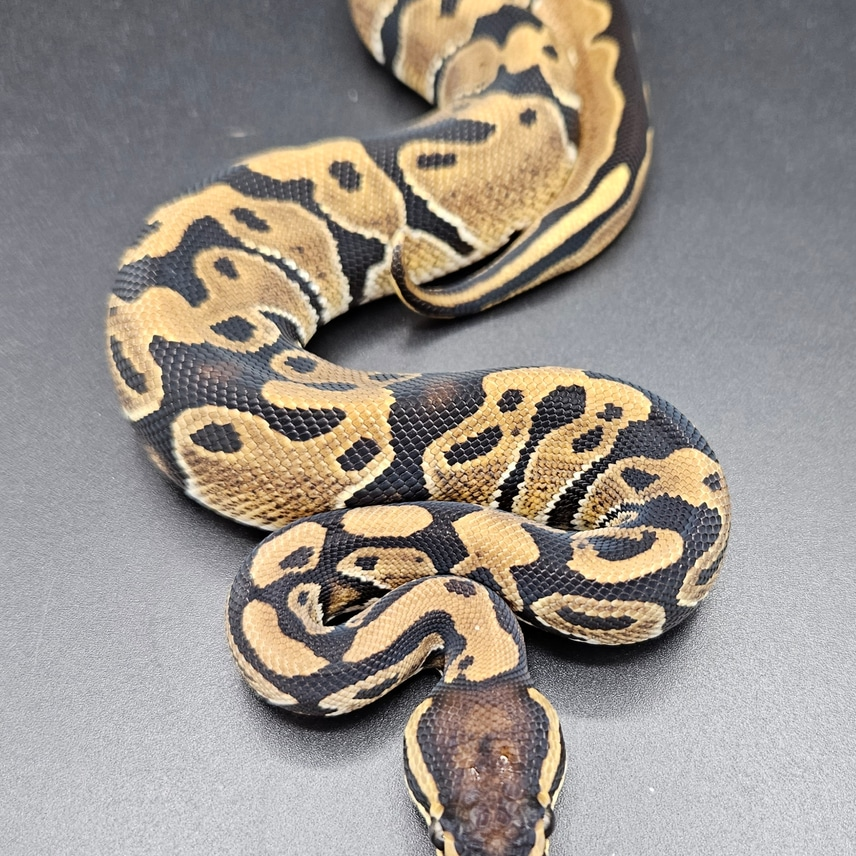

In [7]:
# Prediction from Test set
img_code = np.random.choice(test_df.index)
img = Image.open(f'data/img/{img_code}.png')
input_img = transform(img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)


with torch.no_grad():
    output = efficientnet(input_img)

predicted_probs = torch.sigmoid(output).to('cpu')
prediction = pd.DataFrame(predicted_probs, index=['predictions'],
                          columns=clean_possible_genes).T.sort_values(by=['predictions'], ascending=False)

print(f'True Morphs: {test_df.loc[img_code, "genes"]}')
display(prediction.query('predictions > 0.5'))
img

Predictions for all the pictures for a listing

In [8]:
# Does not work because of random train test split

# img_code = np.random.choice(test_df.index)
# img_code_parent = img_code.split("-")[0]
# test_df.index[test_df.index.astype(str).str.contains(fr'^{img_code_parent}-')].to_list()

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [ ]:
# Loss on test set
test_dataset = PythonGeneDataset(labels_df=test_df, img_dir='data/img/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
focal_loss = FocalLoss()
criterion = focal_loss

efficientnet.eval()  # Set model to evaluate mode

test_loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = efficientnet(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

# Calculate average loss over validation data
test_loss = test_loss / len(test_loader.dataset)
print(f'Loss on Test set: {test_loss:.5f}')

In [9]:
# Prediction on the whole test set
test_df_pred = {}

for img_code in test_df.index:
    img = Image.open(f'data/img/{img_code}.png')
    input_img = transform(img)
    input_img = input_img.unsqueeze(0)
    input_img = input_img.to(device)

    with torch.no_grad():
        output = efficientnet(input_img)

    predicted_probs = torch.sigmoid(output).to('cpu')
    test_df_pred[img_code] = predicted_probs

In [10]:
pred_df = {key: val.numpy().flatten() for key, val in test_df_pred.items()}
pred_df = pd.DataFrame.from_dict(pred_df, orient='index', columns=clean_possible_genes)
pred_df_round = pred_df.round()

In [11]:
def count_matching_elements(list1, list2):
    count = sum(1 for x, y in zip(list1, list2) if x == y)
    return count

count_matching_elements(pred_df_round.loc['12861-1'].to_list(), test_df.loc['12861-1'][6:].to_list())

17

In [12]:
result = []
for idx in pred_df_round.index:
    pred = count_matching_elements(pred_df_round.loc[idx].to_list(), test_df.loc[idx][6:].to_list())
    result.append(pred)
    
for n in range(20, -1, -1):
    print(f'Prediction with {20-n} mistake: {result.count(n) / len(result):.3f}')

Prediction with 0 mistake: 0.585
Prediction with 1 mistake: 0.241
Prediction with 2 mistake: 0.124
Prediction with 3 mistake: 0.036
Prediction with 4 mistake: 0.010
Prediction with 5 mistake: 0.003
Prediction with 6 mistake: 0.001
Prediction with 7 mistake: 0.000
Prediction with 8 mistake: 0.000
Prediction with 9 mistake: 0.000
Prediction with 10 mistake: 0.000
Prediction with 11 mistake: 0.000
Prediction with 12 mistake: 0.000
Prediction with 13 mistake: 0.000
Prediction with 14 mistake: 0.000
Prediction with 15 mistake: 0.000
Prediction with 16 mistake: 0.000
Prediction with 17 mistake: 0.000
Prediction with 18 mistake: 0.000
Prediction with 19 mistake: 0.000
Prediction with 20 mistake: 0.000
